In [1]:
from google.colab import files
uploaded = files.upload()          # choose cleaned_AQI_dataset.csv
# uploaded is a dict; file will be in working dir /content


Saving cleaned_AQI_dataset.csv to cleaned_AQI_dataset (4).csv


In [14]:
# run in a code cell (python magic allowed in Colab)
!pip install -q numpy==1.24.3
!pip install -q pmdarima==2.0.4 prophet xgboost tensorflow scikit-learn statsmodels

  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import timedelta

# Path: change if you mounted Drive, else upload to /content
csv_path = '/content/cleaned_AQI_dataset.csv'   # or '/content/drive/MyDrive/.../cleaned_AQI_dataset.csv'
assert os.path.exists(csv_path), f"File not found: {csv_path}. Upload it or update path."
print("Loading:", csv_path)
df = pd.read_csv(csv_path, low_memory=False)
print("Loaded shape:", df.shape)


Loading: /content/cleaned_AQI_dataset.csv
Loaded shape: (12042, 9)


In [4]:
# find a date column
date_col_candidates = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
date_col = date_col_candidates[0] if date_col_candidates else 'Date'
print("Using date column:", date_col)

df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col]).sort_values(by=date_col).reset_index(drop=True)
df.set_index(date_col, inplace=True)

print("Time span:", df.index.min(), "to", df.index.max())
display(df.head())


Using date column: Date
Time span: 2018-01-01 00:00:00 to 2024-12-31 00:00:00


City    AQI   PM2.5    PM10     NO2     SO2    CO      O3
Date                                                                      
2018-01-01  Bangalore   68.0   37.40   73.44   56.44   77.52  0.71   64.60
2018-01-01    Chennai   93.0   51.15  100.44   77.19  106.02  0.98   88.35
2018-01-01  Hyderabad  119.0   65.45  128.52   98.77  135.66  1.25  113.05
2018-01-01      Delhi  406.0  223.30  438.48  336.98  462.84  4.26  385.70
2018-01-02      Delhi  418.0  229.90  451.44  346.94  476.52  4.39  397.10

In [5]:
missing = df.isna().sum().to_frame('missing').assign(percent=lambda x: 100*x['missing']/len(df))
display(missing)
display(df.select_dtypes(include=[np.number]).describe().T)


missing  percent
City         0      0.0
AQI          0      0.0
PM2.5        0      0.0
PM10         0      0.0
NO2          0      0.0
SO2          0      0.0
CO           0      0.0
O3           0      0.0

count        mean        std   min    25%    50%     75%     max
AQI    12042.0  107.585700  75.025717  19.0  60.00  83.00  124.00  494.00
PM2.5  12042.0   59.167887  41.267603   0.0  33.00  45.65   68.20  271.70
PM10   12042.0  116.184215  81.034565   0.0  64.80  89.64  133.92  533.52
NO2    12042.0   89.289721  62.276564   0.0  49.80  68.89  102.92  410.02
SO2    12042.0  122.638894  85.536486   0.0  68.40  94.62  141.36  563.16
CO     12042.0    1.129895   0.787845   0.0   0.63   0.87    1.30    5.19
O3     12042.0  102.199078  71.280405   0.0  57.00  78.85  117.80  469.30

In [6]:
# Detect pollutants
cols_lower = [c.lower() for c in df.columns]
def find_col(patterns):
    for p in patterns:
        for i,c in enumerate(cols_lower):
            if p in c:
                return df.columns[i]
    return None

pollutants = {
 'PM2.5': ['pm2.5','pm2_5','pm25','pm2'],
 'PM10': ['pm10','pm_10'],
 'NO2': ['no2','no_2'],
 'SO2': ['so2','so_2'],
 'CO': ['co','co_ppm'],
 'O3': ['o3','ozone'],
 'AQI': ['aqi','air_quality_index']
}
found = {k: find_col(v) for k,v in pollutants.items() if find_col(v)}
print("Detected:", found)

# Resample to daily mean for numeric columns only
df_daily = df.resample('D')[df.select_dtypes(include=[np.number]).columns].mean()
print("Daily frame shape:", df_daily.shape)
display(df_daily.head())


Detected: {'PM2.5': 'PM2.5', 'PM10': 'PM10', 'NO2': 'NO2', 'SO2': 'SO2', 'CO': 'CO', 'O3': 'O3', 'AQI': 'AQI'}
Daily frame shape: (2557, 7)


AQI     PM2.5    PM10       NO2      SO2      CO        O3
Date                                                                     
2018-01-01  171.50   94.3250  185.22  142.3450  195.510  1.8000  162.9250
2018-01-02  177.75   97.7625  191.97  147.5325  202.635  1.8675  168.8625
2018-01-03  172.25   94.7375  186.03  142.9675  196.365  1.8100  163.6375
2018-01-04  195.50  107.5250  211.14  162.2650  222.870  2.0500  185.7250
2018-01-05  193.25  106.2875  208.71  160.3975  220.305  2.0300  183.5875

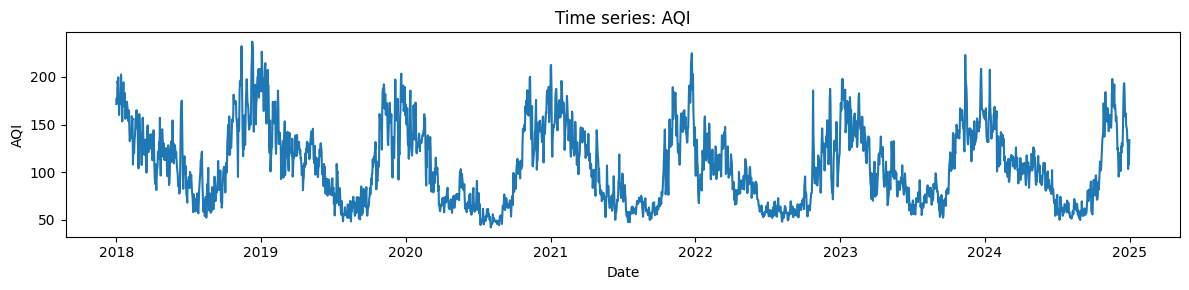

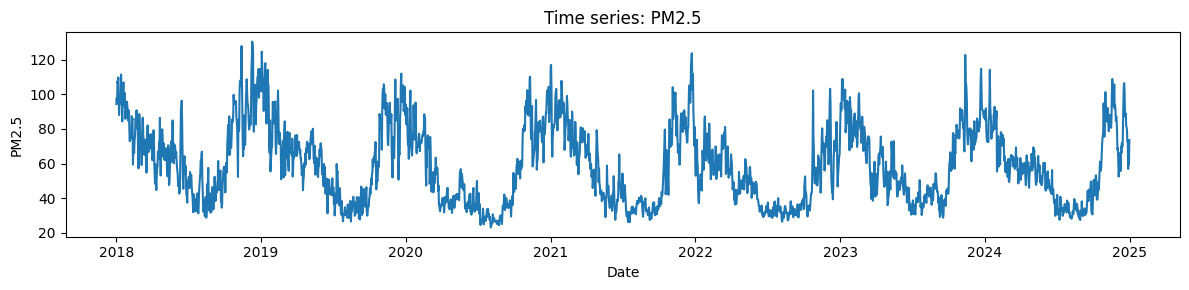

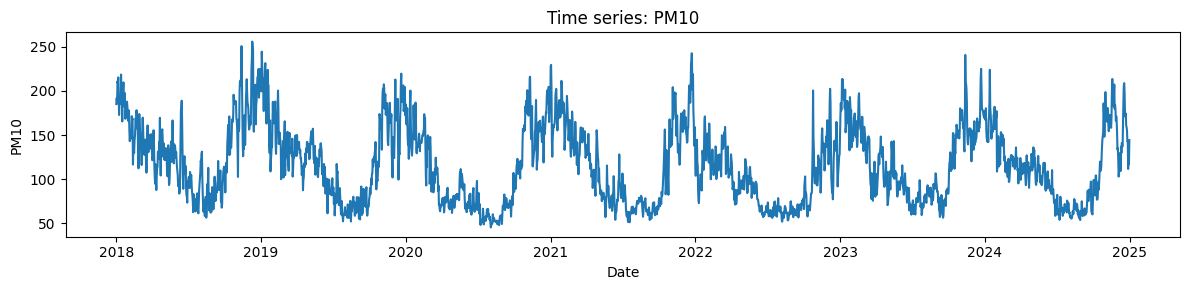

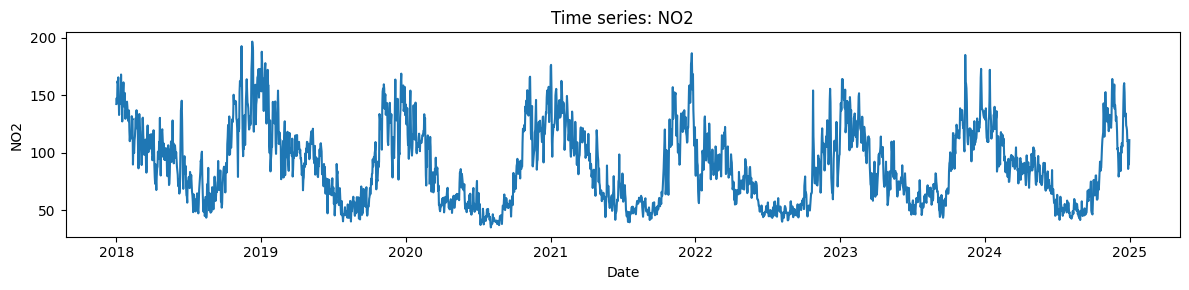

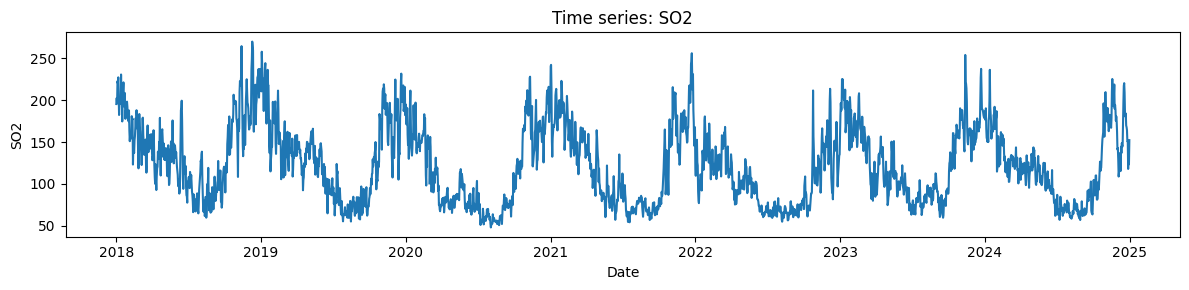

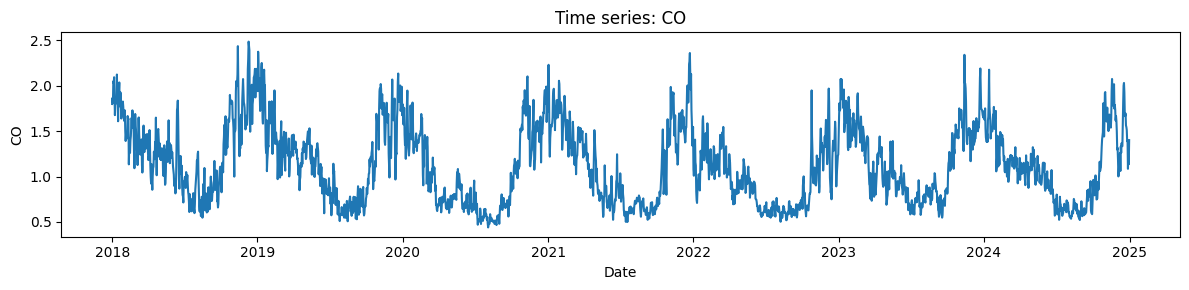

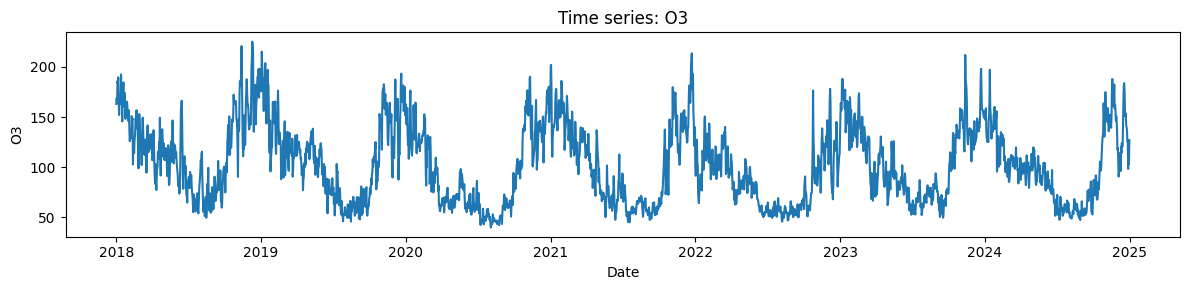

In [7]:
# Pick pollutant columns we detected, else fallback to first few numeric cols
numeric_cols = df_daily.select_dtypes(include=[np.number]).columns
to_plot = [found[k] for k in ['AQI','PM2.5','PM10','NO2','SO2','CO','O3'] if k in found and found[k] in numeric_cols]

if not to_plot:
    to_plot = numeric_cols[:4]  # fallback

for col in to_plot:
    plt.figure(figsize=(12,3))
    plt.plot(df_daily.index, df_daily[col])
    plt.title(f"Time series: {col}")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


AQI     PM2.5      PM10       NO2       SO2        CO        O3
AQI    1.000000  0.999958  0.999958  0.999958  0.999958  0.999953  0.999958
PM2.5  0.999958  1.000000  1.000000  1.000000  1.000000  0.999995  1.000000
PM10   0.999958  1.000000  1.000000  1.000000  1.000000  0.999995  1.000000
NO2    0.999958  1.000000  1.000000  1.000000  1.000000  0.999995  1.000000
SO2    0.999958  1.000000  1.000000  1.000000  1.000000  0.999995  1.000000
CO     0.999953  0.999995  0.999995  0.999995  0.999995  1.000000  0.999995
O3     0.999958  1.000000  1.000000  1.000000  1.000000  0.999995  1.000000

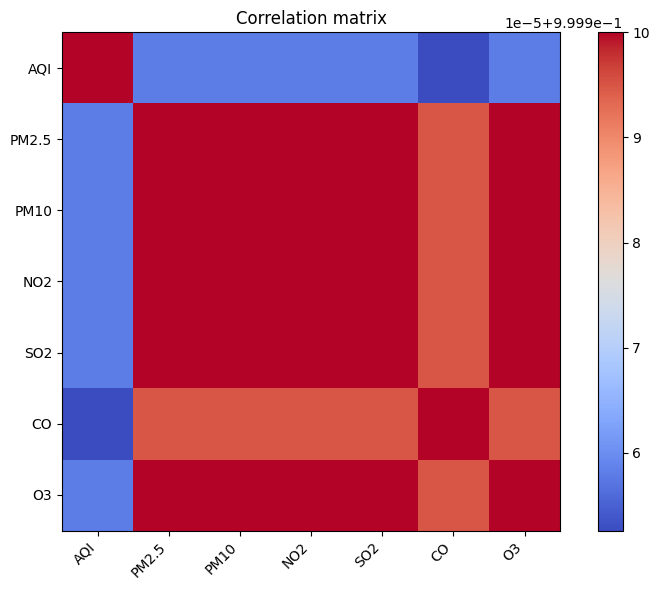

In [8]:
num = df_daily.select_dtypes(include=[np.number])
if num.shape[1] >= 2:
    corr = num.corr()
    display(corr)
    plt.figure(figsize=(8,6))
    plt.imshow(corr, interpolation='nearest', cmap='coolwarm')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title('Correlation matrix')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns to compute correlation.")


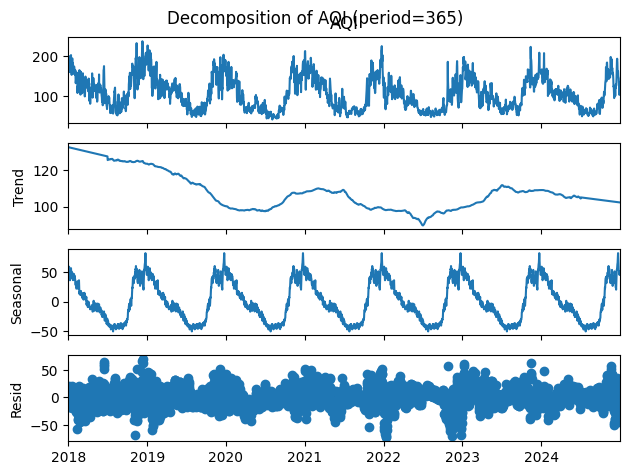

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

num = df_daily.select_dtypes(include=[np.number])
if len(num.columns) > 0:
    target = num.columns[0]  # first numeric pollutant
    s = df_daily[target].interpolate(limit_direction='both')
    period = 365 if len(s) > 400 else 7
    res = seasonal_decompose(s, model='additive', period=period, extrapolate_trend='freq')
    res.plot()
    plt.suptitle(f"Decomposition of {target} (period={period})")
    plt.show()
else:
    print("No numeric columns available for seasonal decomposition.")


In [10]:
df_features = df_daily.copy()
df_features['dayofweek'] = df_features.index.dayofweek
df_features['month'] = df_features.index.month
df_features['is_weekend'] = df_features['dayofweek'].isin([5,6]).astype(int)

num_cols = df_features.select_dtypes(include=[np.number]).columns
for c in num_cols[:3]:
    df_features[f'{c}_7d_avg'] = df_features[c].rolling(7, min_periods=1).mean()

display(df_features.head())


AQI     PM2.5    PM10       NO2      SO2      CO        O3  \
Date                                                                        
2018-01-01  171.50   94.3250  185.22  142.3450  195.510  1.8000  162.9250   
2018-01-02  177.75   97.7625  191.97  147.5325  202.635  1.8675  168.8625   
2018-01-03  172.25   94.7375  186.03  142.9675  196.365  1.8100  163.6375   
2018-01-04  195.50  107.5250  211.14  162.2650  222.870  2.0500  185.7250   
2018-01-05  193.25  106.2875  208.71  160.3975  220.305  2.0300  183.5875   

            dayofweek  month  is_weekend  AQI_7d_avg  PM2.5_7d_avg  \
Date                                                                 
2018-01-01          0      1           0  171.500000     94.325000   
2018-01-02          1      1           0  174.625000     96.043750   
2018-01-03          2      1           0  173.833333     95.608333   
2018-01-04          3      1           0  179.250000     98.587500   
2018-01-05          4      1           0  182.050000    100.127500   

            PM10_7d_avg  
Date                     
2018-01-01      185.220  
2018-01-02      188.595  
2018-01-03      187.740  
2018-01-04      193.590  
2018-01-05      196.614


=== Forecasting PM2.5 ===
RMSE: 14.65, MAE: 11.90


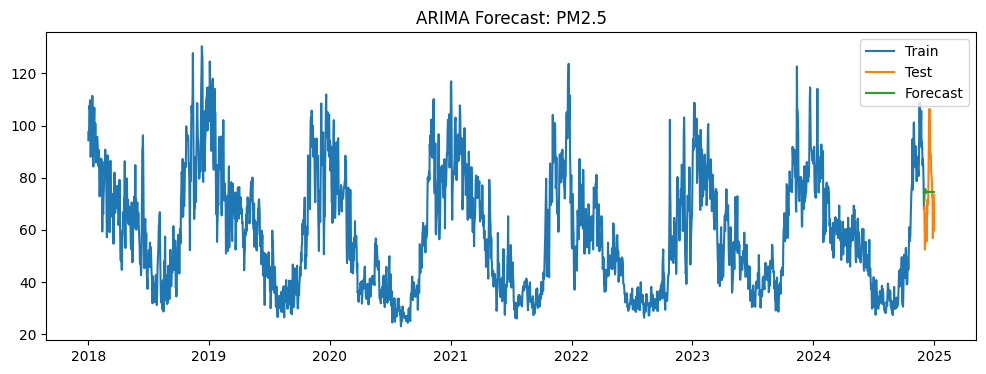


=== Forecasting PM10 ===
RMSE: 28.77, MAE: 23.36


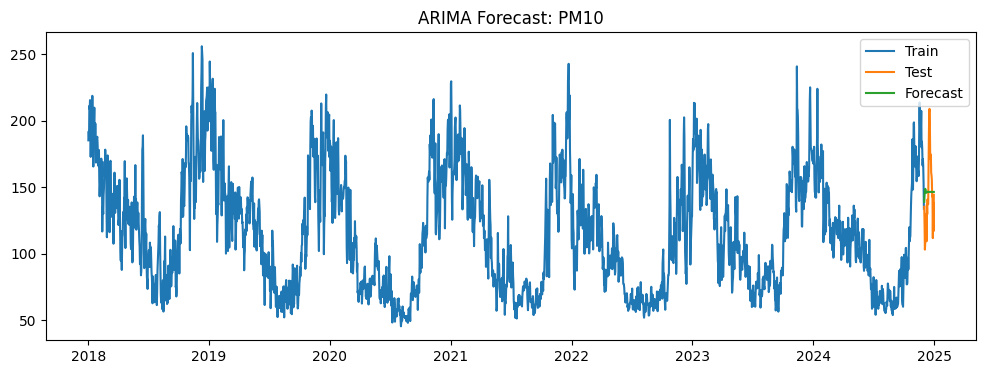


=== Forecasting NO2 ===
RMSE: 22.11, MAE: 17.95


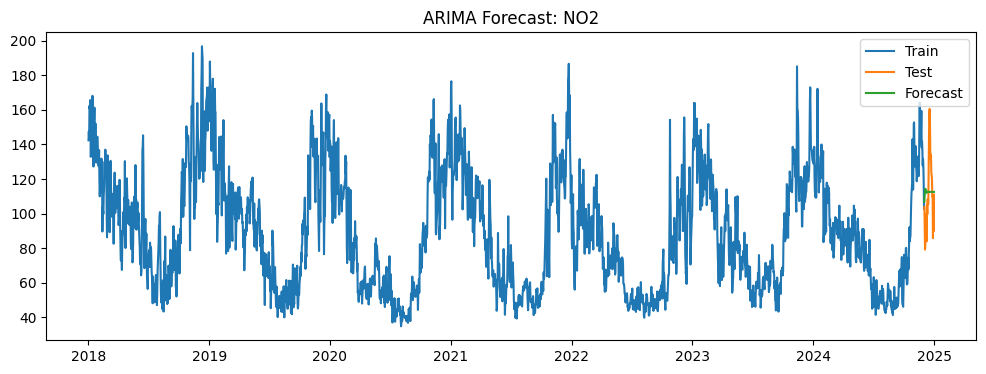


=== Forecasting SO2 ===
RMSE: 30.37, MAE: 24.66


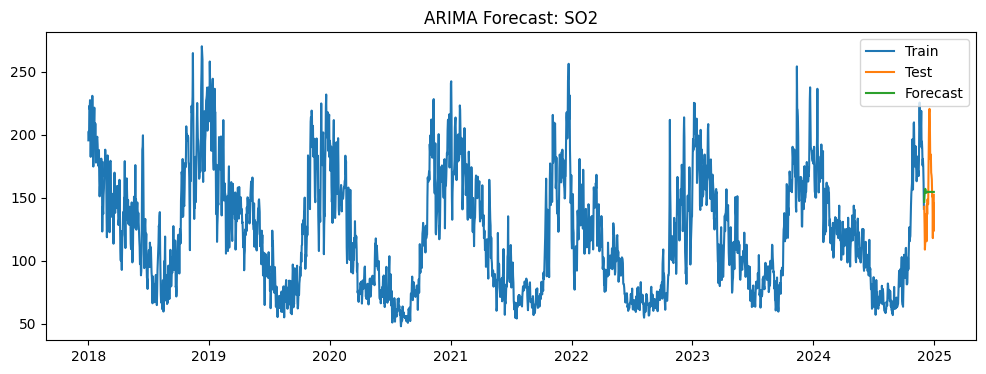


=== Forecasting CO ===
RMSE: 0.28, MAE: 0.23


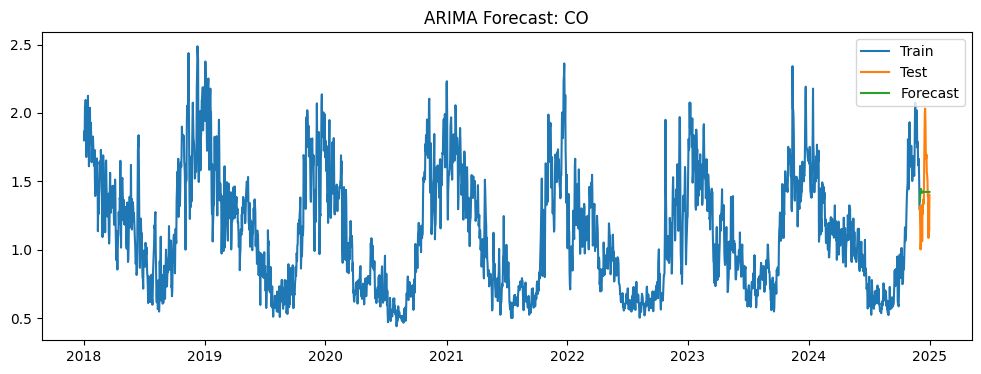


=== Forecasting O3 ===
RMSE: 25.31, MAE: 20.55


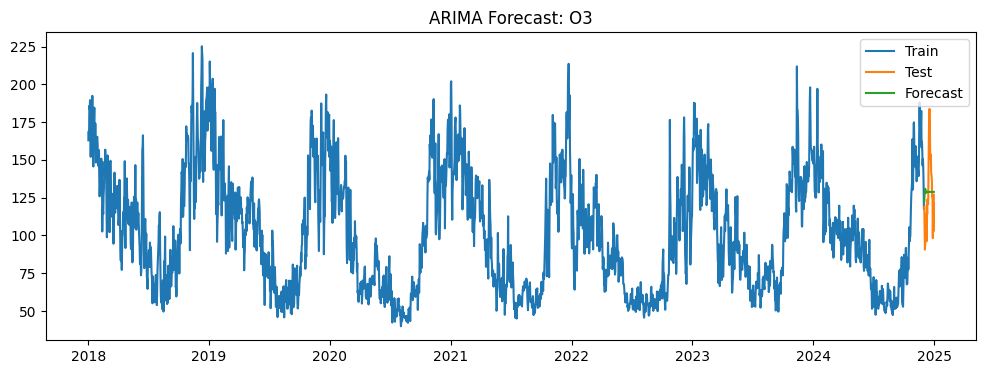

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Pick numeric pollutant columns
numeric_cols = df_daily.select_dtypes(include=[np.number]).columns
pollutants_to_forecast = [found[k] for k in ['PM2.5','PM10','NO2','SO2','CO','O3'] if k in found and found[k] in numeric_cols]

# Forecast horizon
forecast_days = 30

# Loop over each pollutant
results = {}

for col in pollutants_to_forecast:
    print(f"\n=== Forecasting {col} ===")
    series = df_daily[col].interpolate(limit_direction='both')

    # Train/test split
    train = series.iloc[:-forecast_days]
    test = series.iloc[-forecast_days:]

    # Fit ARIMA (simple example: order=(5,1,0); can tune)
    model = ARIMA(train, order=(5,1,0))
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=forecast_days)

    # Evaluate
    rmse = math.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    # Store results
    results[col] = {'model': model_fit, 'forecast': forecast, 'test': test, 'rmse': rmse, 'mae': mae}

    # Plot
    plt.figure(figsize=(12,4))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(f"ARIMA Forecast: {col}")
    plt.legend()
    plt.show()



Training Prophet for PM2.5...


DEBUG:cmdstanpy:input tempfile: /tmp/tmplmvjdex2/gvmztpe8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplmvjdex2/toqp3wbv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45124', 'data', 'file=/tmp/tmplmvjdex2/gvmztpe8.json', 'init=/tmp/tmplmvjdex2/toqp3wbv.json', 'output', 'file=/tmp/tmplmvjdex2/prophet_model_jtyv7lt/prophet_model-20250927143940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:39:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:39:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


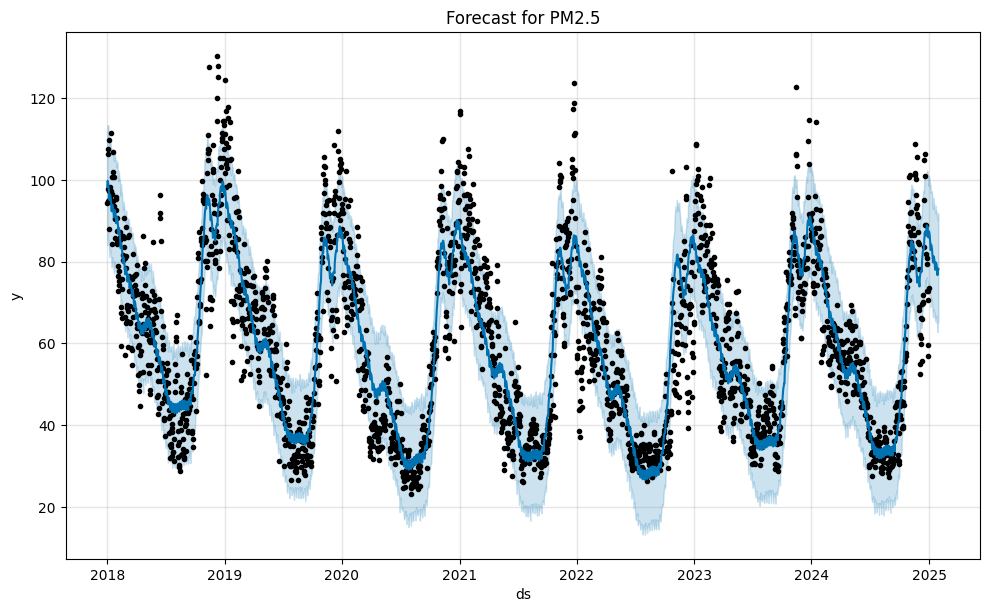

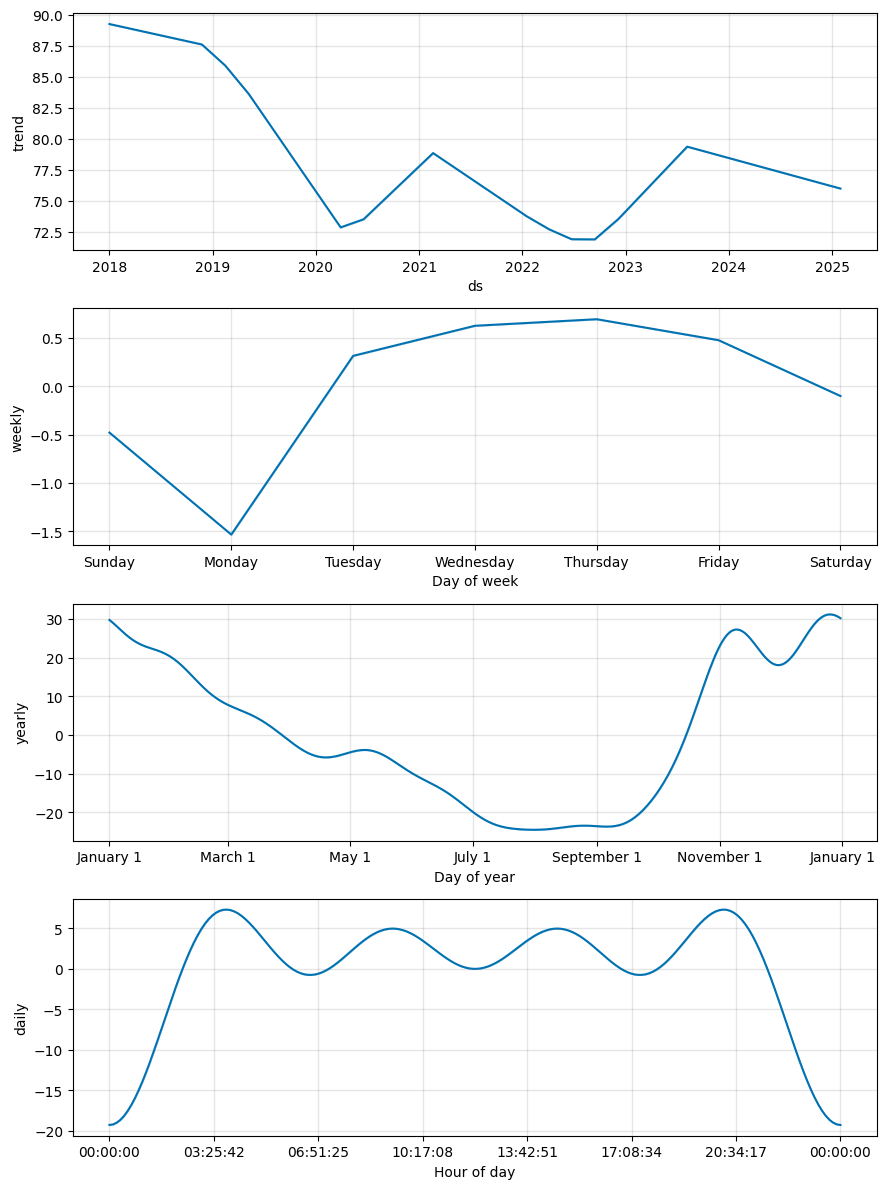

DEBUG:cmdstanpy:input tempfile: /tmp/tmplmvjdex2/grlj0167.json



Training Prophet for PM10...


DEBUG:cmdstanpy:input tempfile: /tmp/tmplmvjdex2/2p1be0mf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29122', 'data', 'file=/tmp/tmplmvjdex2/grlj0167.json', 'init=/tmp/tmplmvjdex2/2p1be0mf.json', 'output', 'file=/tmp/tmplmvjdex2/prophet_model1foovvlz/prophet_model-20250927143945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:39:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:39:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


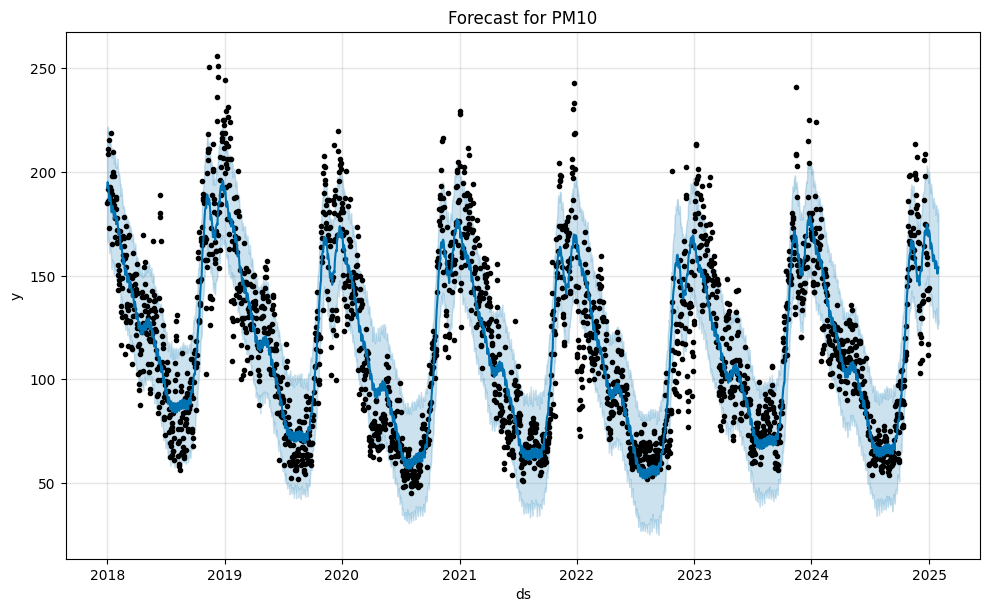

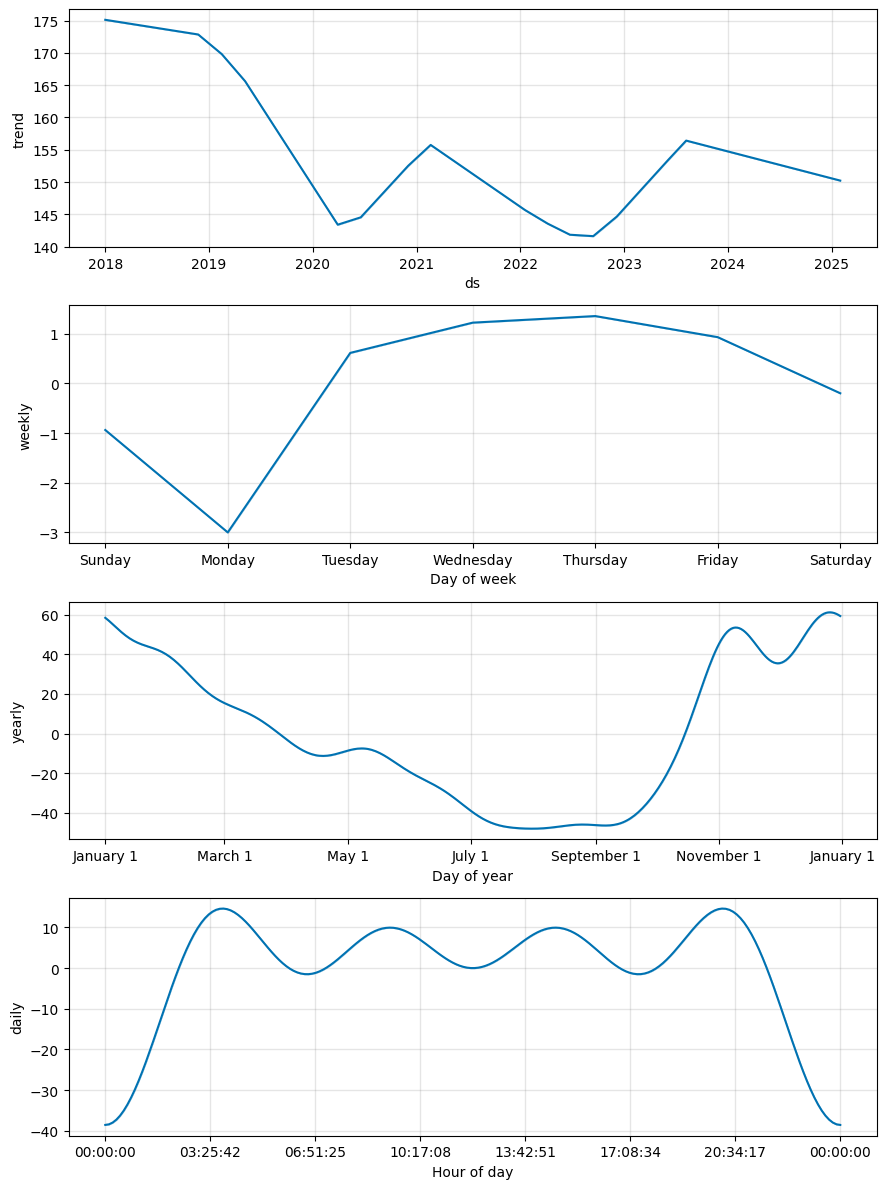

DEBUG:cmdstanpy:input tempfile: /tmp/tmplmvjdex2/m7ipxjdm.json



Training Prophet for NO2...


DEBUG:cmdstanpy:input tempfile: /tmp/tmplmvjdex2/ejkp44wx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69335', 'data', 'file=/tmp/tmplmvjdex2/m7ipxjdm.json', 'init=/tmp/tmplmvjdex2/ejkp44wx.json', 'output', 'file=/tmp/tmplmvjdex2/prophet_model2pnm_ybo/prophet_model-20250927143947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:39:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:39:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


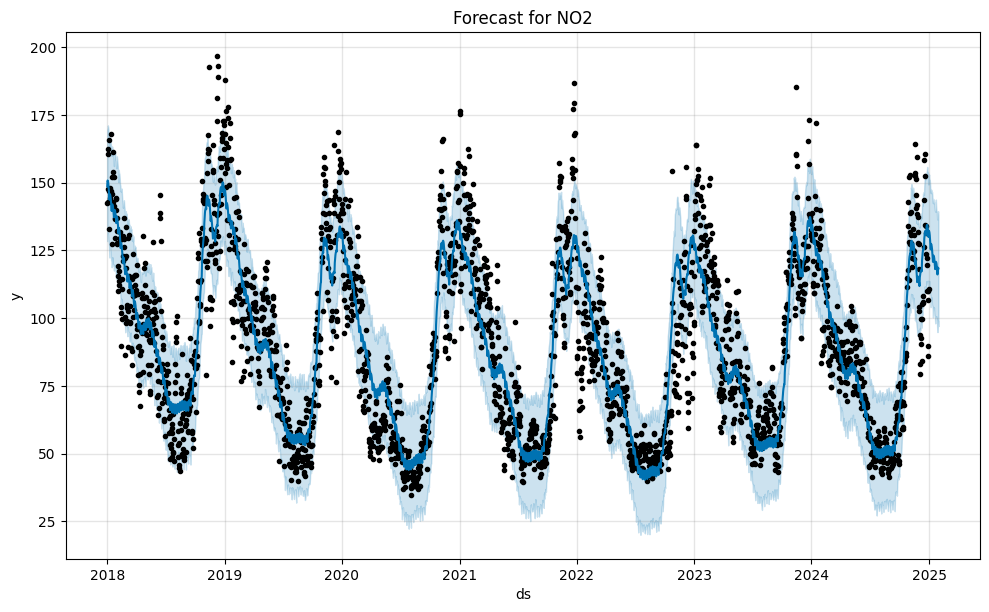

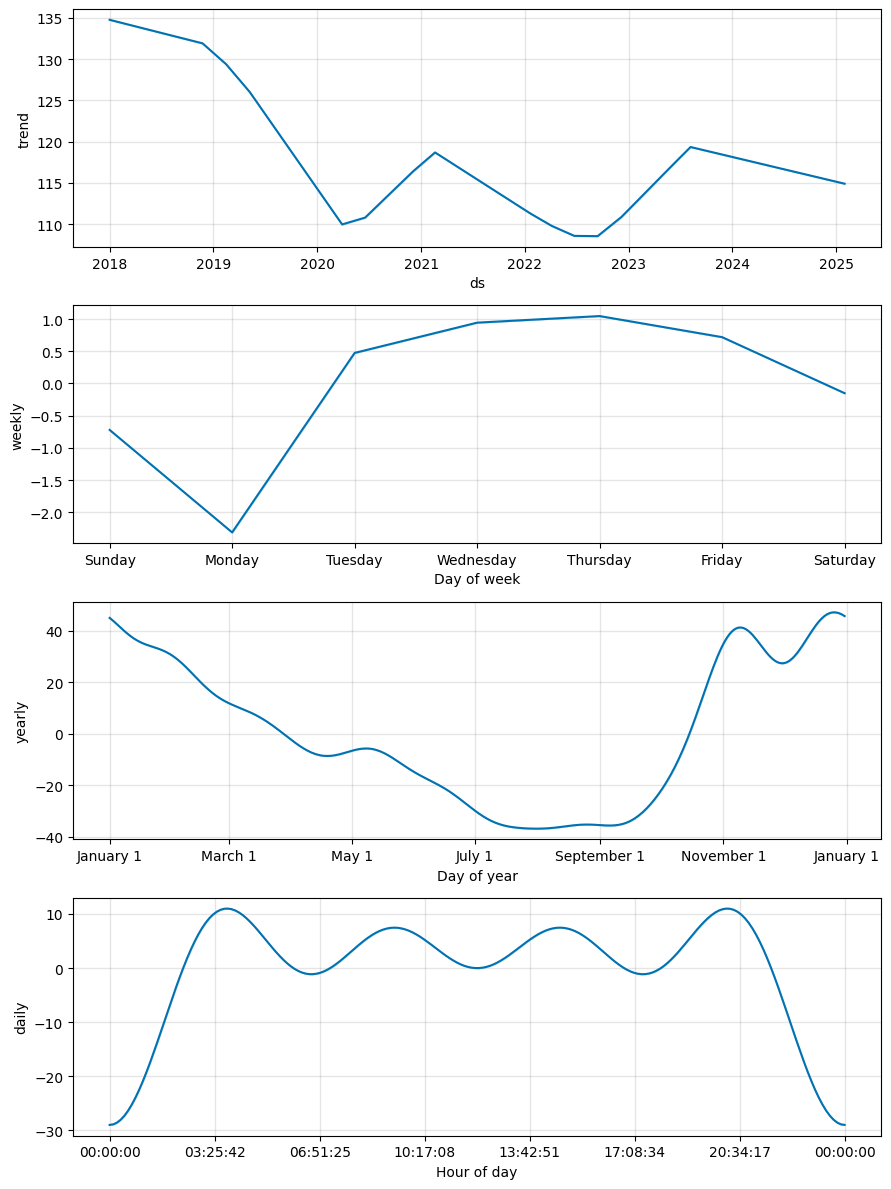

DEBUG:cmdstanpy:input tempfile: /tmp/tmplmvjdex2/1jobqg5v.json



Training Prophet for SO2...


DEBUG:cmdstanpy:input tempfile: /tmp/tmplmvjdex2/qd7tj7em.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14479', 'data', 'file=/tmp/tmplmvjdex2/1jobqg5v.json', 'init=/tmp/tmplmvjdex2/qd7tj7em.json', 'output', 'file=/tmp/tmplmvjdex2/prophet_modeljgzu385v/prophet_model-20250927143950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:39:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:39:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


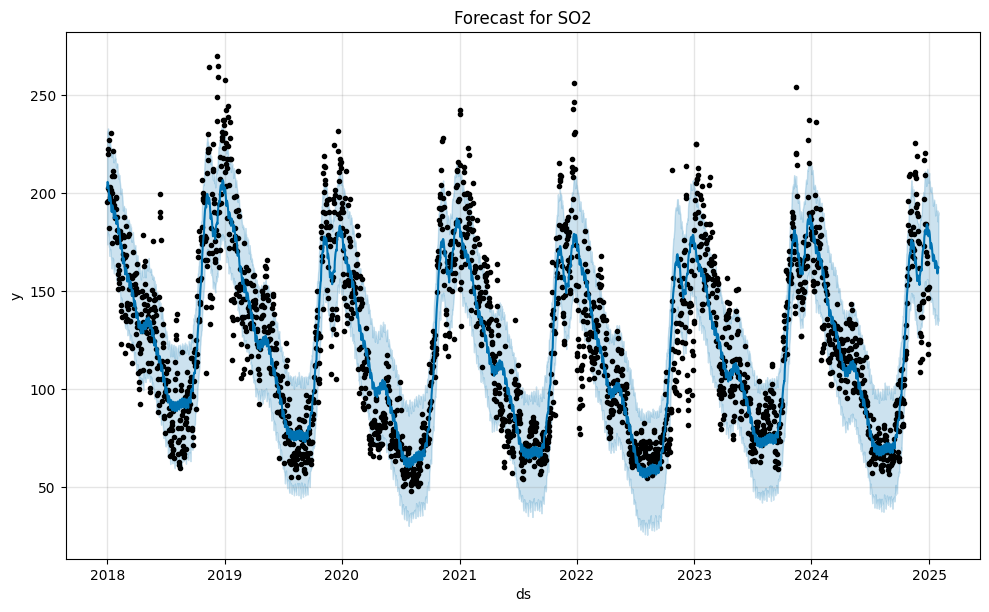

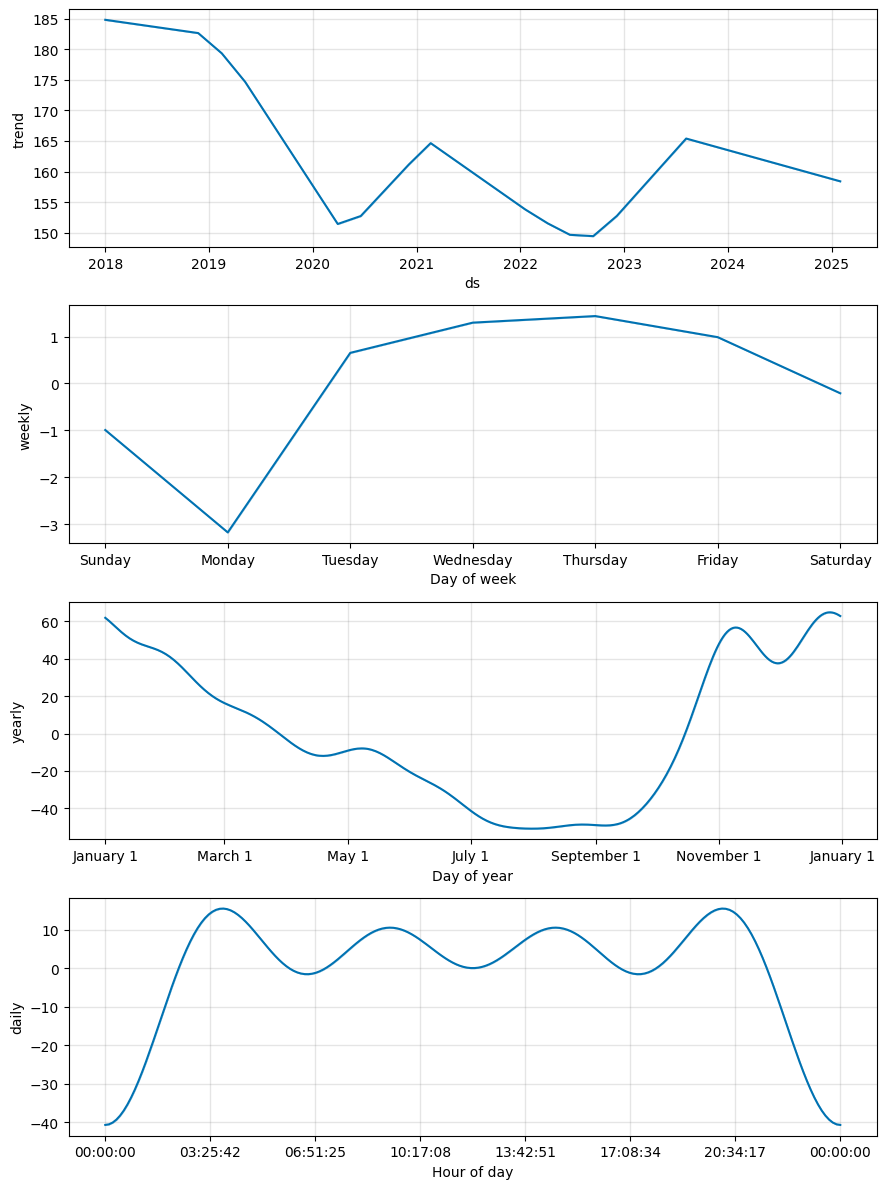

DEBUG:cmdstanpy:input tempfile: /tmp/tmplmvjdex2/7d7m2x6u.json



Training Prophet for CO...


DEBUG:cmdstanpy:input tempfile: /tmp/tmplmvjdex2/4avkuj6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96817', 'data', 'file=/tmp/tmplmvjdex2/7d7m2x6u.json', 'init=/tmp/tmplmvjdex2/4avkuj6n.json', 'output', 'file=/tmp/tmplmvjdex2/prophet_modelqhtfyim5/prophet_model-20250927143953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:39:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


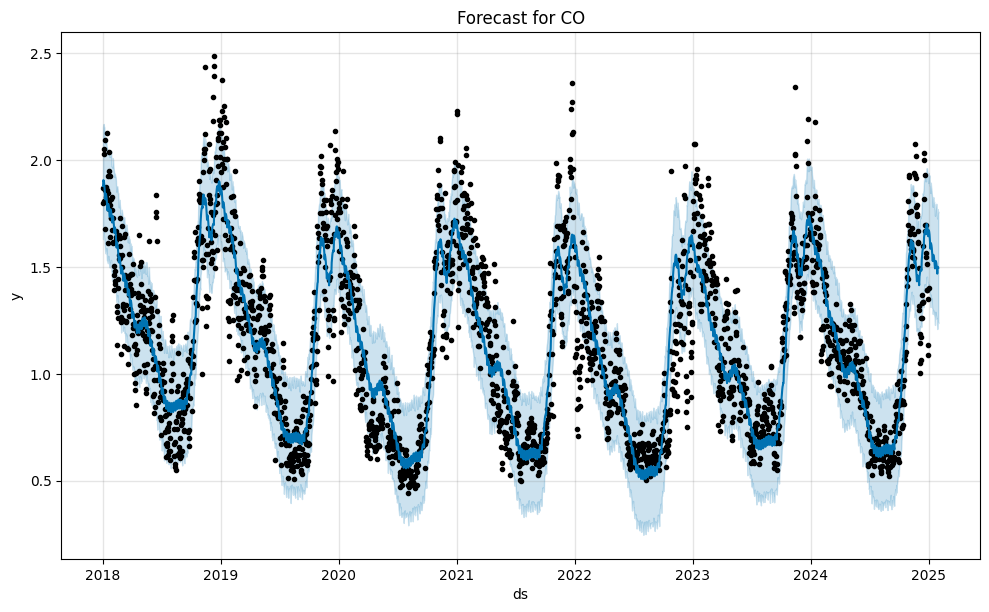

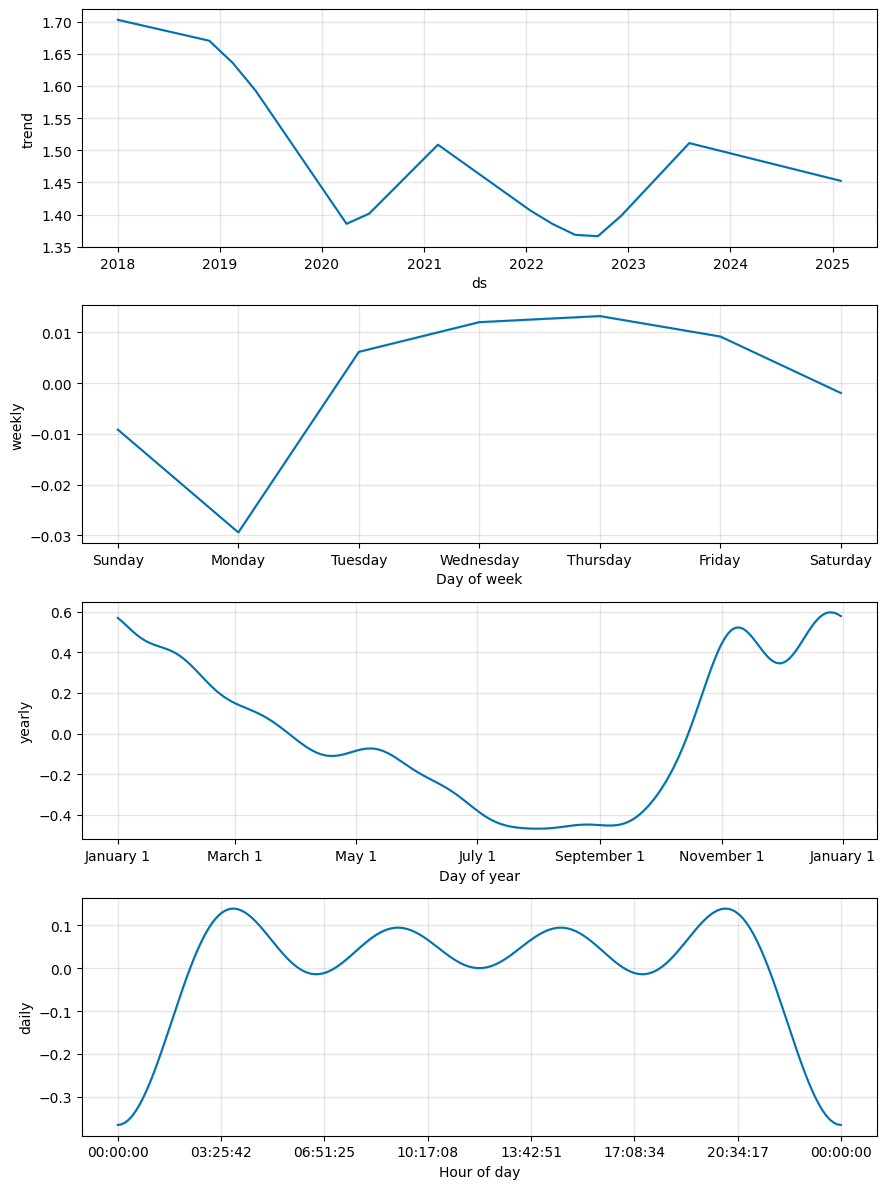

DEBUG:cmdstanpy:input tempfile: /tmp/tmplmvjdex2/giilemr4.json



Training Prophet for O3...


DEBUG:cmdstanpy:input tempfile: /tmp/tmplmvjdex2/75q8vg6m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65188', 'data', 'file=/tmp/tmplmvjdex2/giilemr4.json', 'init=/tmp/tmplmvjdex2/75q8vg6m.json', 'output', 'file=/tmp/tmplmvjdex2/prophet_modeljeybqnx0/prophet_model-20250927143955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:39:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:39:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


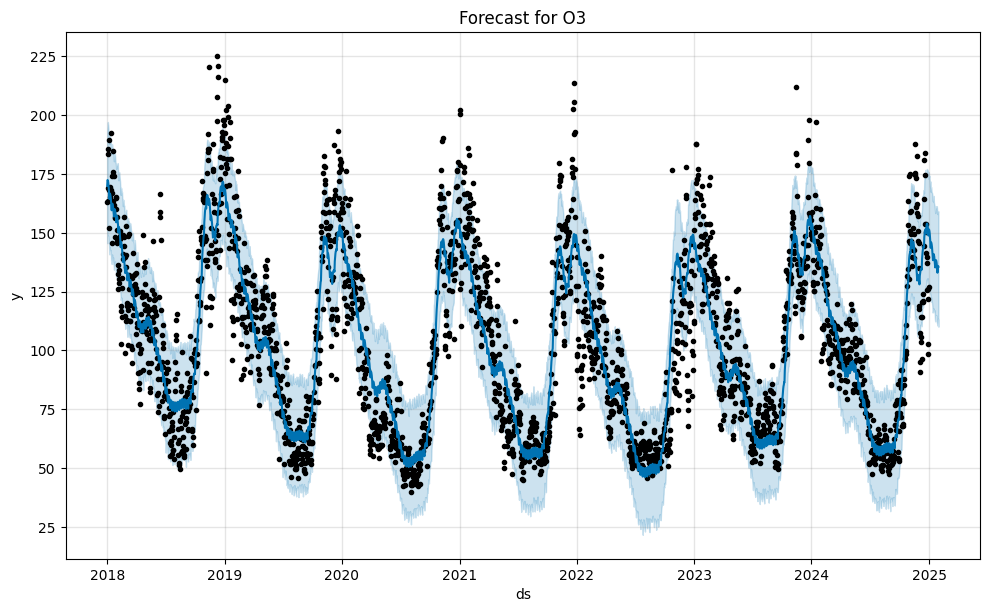

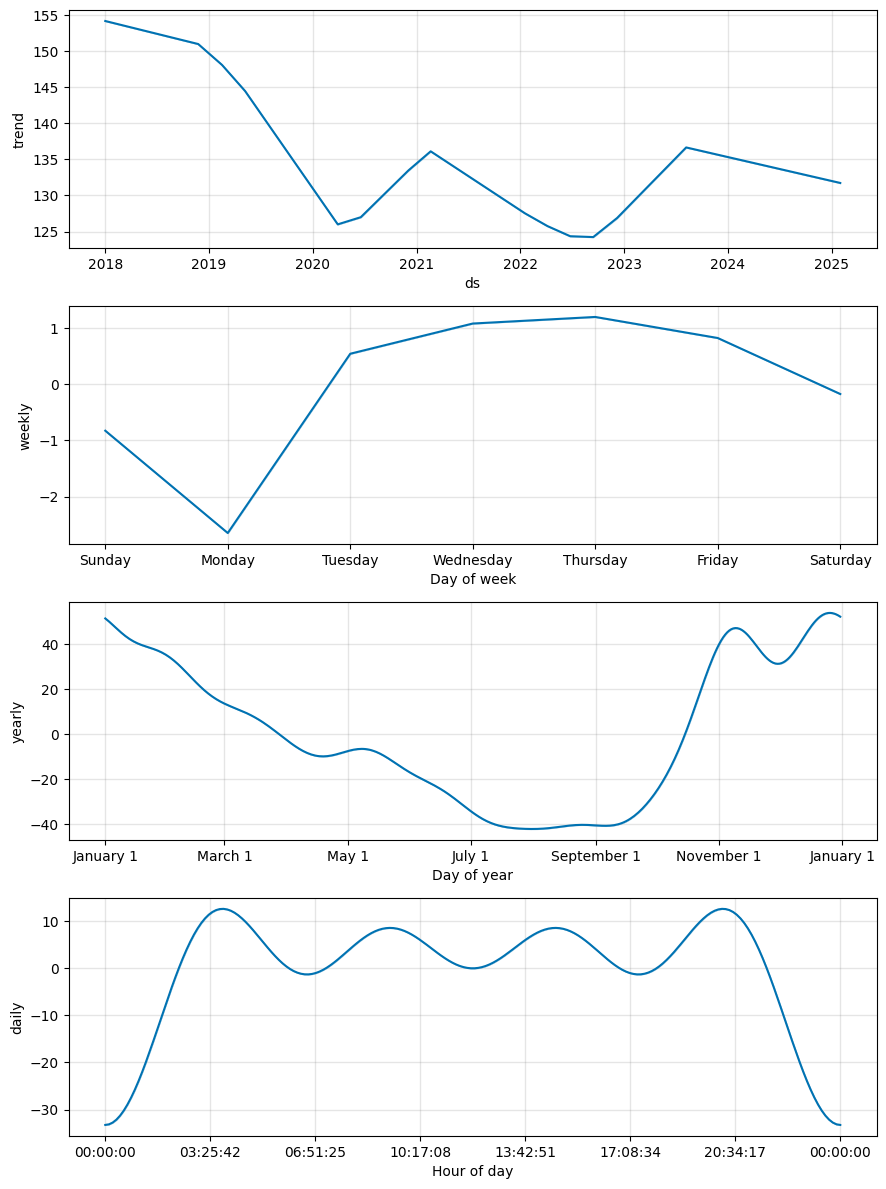

In [20]:
from prophet import Prophet

# Select pollutants to forecast (exclude AQI)
pollutant_cols = [found[k] for k in ['PM2.5','PM10','NO2','SO2','CO','O3'] if k in found]

forecasts = {}  # store forecast dfs
models = {}     # store trained models

for col in pollutant_cols:
    print(f"\nTraining Prophet for {col}...")

    # Prepare data
    df_prophet = df_daily[[col]].reset_index().rename(columns={date_col:'ds', col:'y'})
    df_prophet['y'] = df_prophet['y'].interpolate(limit_direction='both')

    # Initialize and fit model
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    m.fit(df_prophet)

    # Forecast next 30 days
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)

    # Save
    forecasts[col] = forecast
    models[col] = m

    # Plot forecast
    fig = m.plot(forecast)
    plt.title(f"Forecast for {col}")
    plt.show()

    # Plot components
    fig2 = m.plot_components(forecast)
    plt.show()



Training LSTM for PM2.5...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


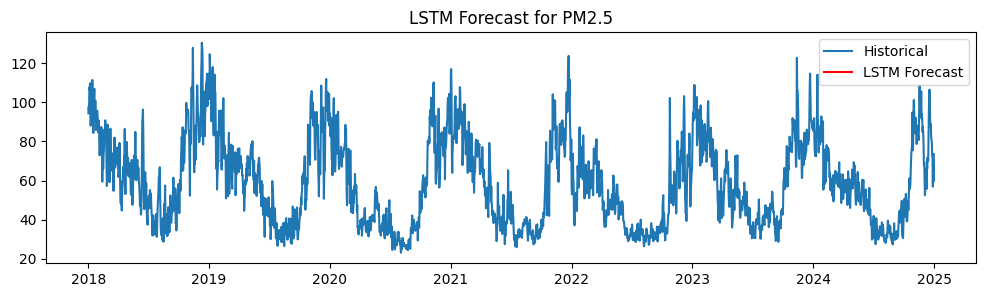


Training LSTM for PM10...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


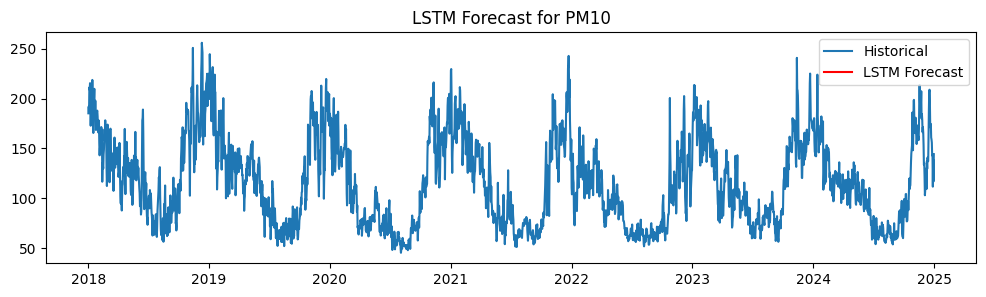


Training LSTM for NO2...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


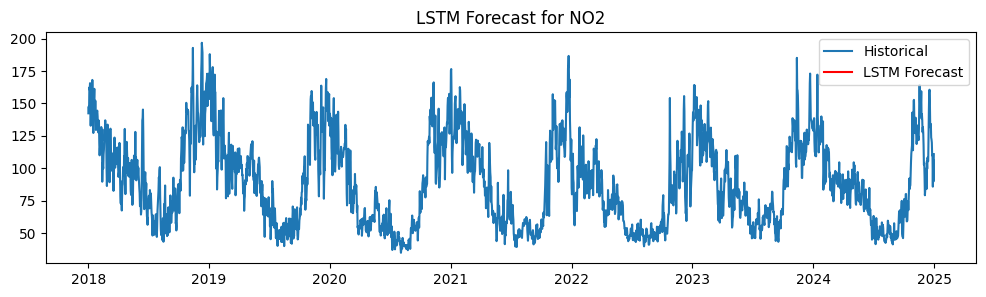


Training LSTM for SO2...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


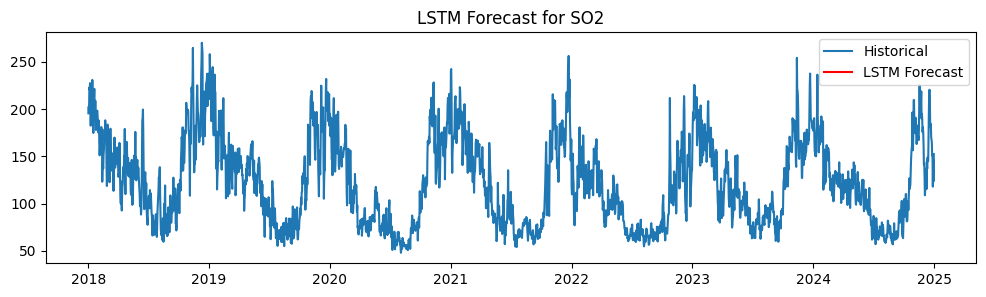


Training LSTM for CO...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


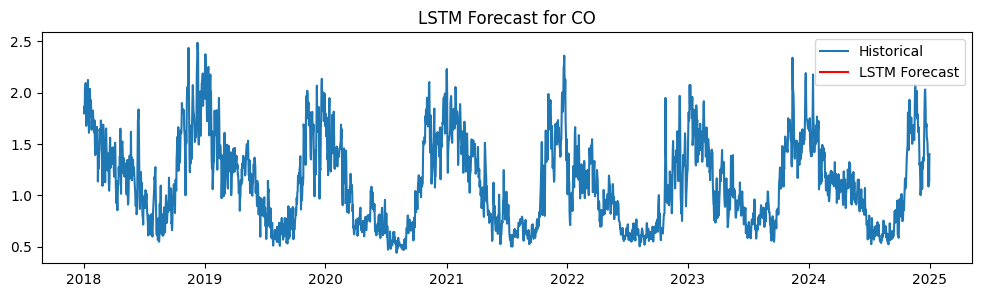


Training LSTM for O3...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


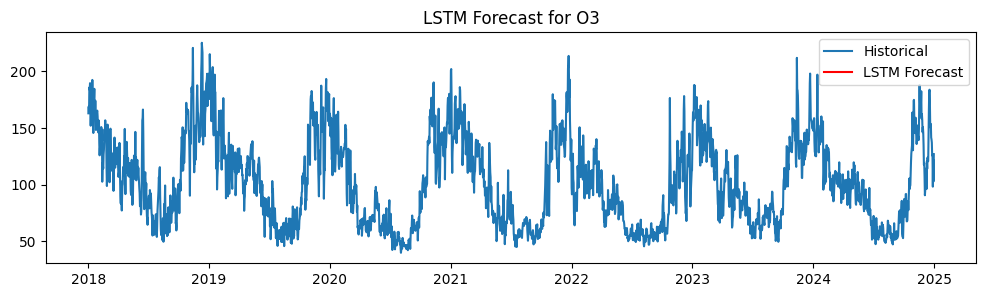

In [21]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Parameters
sequence_length = 30  # past 30 days to predict next day
forecast_days = 30    # predict 30 days ahead

pollutant_cols = [found[k] for k in ['PM2.5','PM10','NO2','SO2','CO','O3'] if k in found]

lstm_forecasts = {}
scalers = {}

for col in pollutant_cols:
    print(f"\nTraining LSTM for {col}...")

    # Prepare series
    series = df_daily[[col]].values
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series)
    scalers[col] = scaler

    # Create sequences
    X, y = [], []
    for i in range(len(series_scaled)-sequence_length):
        X.append(series_scaled[i:i+sequence_length])
        y.append(series_scaled[i+sequence_length])
    X, y = np.array(X), np.array(y)

    # Train/test split (80/20)
    split = int(0.8*len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    # Build LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(sequence_length,1)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    # Forecast next 30 days
    forecast_scaled = []
    last_seq = series_scaled[-sequence_length:]  # last known sequence

    for _ in range(forecast_days):
        pred = model.predict(last_seq.reshape(1, sequence_length, 1), verbose=0)
        forecast_scaled.append(pred[0,0])
        last_seq = np.roll(last_seq, -1)
        last_seq[-1] = pred  # append prediction

    forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1,1))
    lstm_forecasts[col] = forecast

    # Plot
    plt.figure(figsize=(12,3))
    plt.plot(df_daily.index, df_daily[col], label='Historical')
    future_index = pd.date_range(df_daily.index[-1]+pd.Timedelta(days=1), periods=forecast_days)
    plt.plot(future_index, forecast, label='LSTM Forecast', color='red')
    plt.title(f"LSTM Forecast for {col}")
    plt.legend()
    plt.show()


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

prophet_errors = {}
for col in pollutant_cols:
    actual = df_daily[col].iloc[-forecast_days:]
    forecast = forecasts[col]['yhat'].iloc[-forecast_days:]
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    prophet_errors[col] = {'rmse': rmse, 'mae': mae}
    print(f"Prophet {col}: RMSE={rmse:.2f}, MAE={mae:.2f}")


Prophet PM2.5: RMSE=17.37, MAE=14.74
Prophet PM10: RMSE=34.23, MAE=29.04
Prophet NO2: RMSE=26.33, MAE=22.34
Prophet SO2: RMSE=36.04, MAE=30.58
Prophet CO: RMSE=0.33, MAE=0.28
Prophet O3: RMSE=30.18, MAE=25.61


In [25]:
best_models = {}
for col in pollutant_cols:
    errors = {
        'ARIMA': results[col]['rmse'],
        'Prophet': prophet_errors[col]['rmse'],
        # 'LSTM': lstm_errors[col]['rmse'] # Exclude LSTM for now as its evaluation failed
    }
    best_model_name = min(errors, key=errors.get)
    best_models[col] = best_model_name
    print(f"Best model for {col}: {best_model_name}")

Best model for PM2.5: ARIMA
Best model for PM10: ARIMA
Best model for NO2: ARIMA
Best model for SO2: ARIMA
Best model for CO: ARIMA
Best model for O3: ARIMA


In [26]:
import pickle

for col in pollutant_cols:
    print(f"Saving ARIMA model for {col}...")
    with open(f'ARIMA_{col}.pkl', 'wb') as f:
        pickle.dump(results[col]['model'], f)


Saving ARIMA model for PM2.5...
Saving ARIMA model for PM10...
Saving ARIMA model for NO2...
Saving ARIMA model for SO2...
Saving ARIMA model for CO...
Saving ARIMA model for O3...


In [27]:
from google.colab import files

# List of pollutants
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']

# Loop through each pollutant and download its ARIMA model
for col in pollutants:
    filename = f'ARIMA_{col}.pkl'
    try:
        files.download(filename)
        print(f"Downloading {filename}...")
    except Exception as e:
        print(f"Could not download {filename}: {e}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
# Show last 10 rows of your dataset
df_daily.tail(10)


AQI  PM2.5     PM10      NO2      SO2     CO      O3
Date                                                              
2024-12-22  161.6  88.88  174.528  134.128  184.224  1.696  153.52
2024-12-23  149.0  81.95  160.920  123.670  169.860  1.564  141.55
2024-12-24  147.2  80.96  158.976  122.176  167.808  1.546  139.84
2024-12-25  144.2  79.31  155.736  119.686  164.388  1.514  136.99
2024-12-26  132.4  72.82  142.992  109.892  150.936  1.390  125.78
2024-12-27  132.6  72.93  143.208  110.058  151.164  1.394  125.97
2024-12-28  103.4  56.87  111.672   85.822  117.876  1.086   98.23
2024-12-29  128.4  70.62  138.672  106.572  146.376  1.348  121.98
2024-12-30  108.2  59.51  116.856   89.806  123.348  1.136  102.79
2024-12-31  133.6  73.48  144.288  110.888  152.304  1.402  126.92

In [47]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# --- Parameters ---
forecast_days = 10
# pollutants = ['PM2.5','PM10','NO2','SO2','CO','O3'] # Use the list from previous cells if needed, or iterate over results keys

# --- Use ARIMA models from previous analysis ---
# The 'results' dictionary contains models trained on data excluding the last 30 days
if 'results' not in globals() or not results:
    raise RuntimeError("ARIMA models not found in 'results' dictionary. Please run the ARIMA forecasting cell first.")

arima_models = {col: result['model'] for col, result in results.items()}
pollutants_to_forecast = list(arima_models.keys())

if not pollutants_to_forecast:
    raise ValueError("No ARIMA models available for forecasting.")

# --- Determine the start date for the forecast ---
# The models in 'results' were trained on data excluding the last 30 days of df_daily
# So, the forecast should start from the day after the end of the training data used in cell GtRuMgkNkR69
# The end of the training data for each pollutant is train.index.max() within the loop in GtRuMgkNkR69
# We can find the earliest start date among all models' forecast indices as the beginning of our 10-day forecast.
# Alternatively, and simpler, we can assume the training data ended 30 days before the end of df_daily.
# Let's get the start date from the first model's forecast index as they all forecast for the same number of steps.
example_forecast = list(arima_models.values())[0].forecast(steps=forecast_days)
forecast_start_date = example_forecast.index.min()

future_dates = pd.date_range(start=forecast_start_date, periods=forecast_days)


# --- Forecast each pollutant and store as Series ---
forecast_dict = {}
for col in pollutants_to_forecast:
    model = arima_models[col]
    # Forecast next n days - returns a Series with the correct date index
    forecast_series = model.forecast(steps=forecast_days)
    # Ensure forecast values are non-negative
    forecast_series[forecast_series < 0] = 0
    forecast_dict[col] = forecast_series

# --- Combine into forecast DataFrame ---
forecast_df = pd.DataFrame(forecast_dict)
forecast_df.index.name = 'Date' # Set index name for consistency

# --- AQI calculation ---
# Example breakpoints (adjust based on your AQI standard)
aqi_breakpoints = {
    'PM2.5': [(0,12,0,50),(12.1,35.4,51,100),(35.5,55.4,101,150),(55.5,150.4,151,200),(150.5,250.4,201,300),(250.5,350.4,301,400),(350.5,500.4,401,500)],
    'PM10': [(0,54,0,50),(55,154,51,100),(155,254,101,150),(255,354,151,200),(355,424,201,300),(425,504,301,400),(505,604,401,500)],
    'NO2': [(0,53,0,50),(54,100,51,100),(101,360,101,150),(361,649,151,200),(650,1249,201,300),(1250,1649,301,400),(1650,2049,401,500)],
    'SO2': [(0,35,0,50),(36,75,51,100),(76,185,101,150),(186,304,151,200),(305,604,201,300),(605,804,301,400),(805,1004,401,500)],
    'CO': [(0,4.4,0,50),(4.5,9.4,51,100),(9.5,12.4,101,150),(12.5,15.2,151,200),(15.3,30.4,201,300),(30.5,40.4,301,400),(40.5,50.4,401,500)],
    'O3': [(0,54,0,50),(55,70,51,100),(71,85,101,150),(86,105,151,200),(106,200,201,300),(201,400,301,400),(401,500,401,500)]
}

def calc_aqi(conc, breakpoints):
    # Handle values below the lowest breakpoint
    if conc < breakpoints[0][0]:
        return breakpoints[0][2]

    for Clow, Chigh, Ilow, Ihigh in breakpoints:
        if Clow <= conc <= Chigh:
            # Avoid division by zero if Chigh == Clow
            if Chigh == Clow:
                return Ilow
            return (Ihigh - Ilow) / (Chigh - Clow) * (conc - Clow) + Ilow

    # Handle values above the highest breakpoint, assume highest interval
    # This assumes breakpoints are ordered by concentration
    # Also handle values below the lowest breakpoint
    if conc < breakpoints[0][0]:
         return breakpoints[0][2]
    elif conc > breakpoints[-1][1]:
         return breakpoints[-1][3]


# Compute AQI = max of individual pollutant AQIs for available pollutants
forecast_df['AQI'] = forecast_df.apply(
    lambda row: max(calc_aqi(row[col], aqi_breakpoints[col]) for col in pollutants_to_forecast if col in aqi_breakpoints),
    axis=1
)


# ------------------------------
# 7️⃣ Show and download
# ------------------------------
print("Forecast for next 10 days:")
display(forecast_df)

forecast_df.to_csv('forecasted_AQI_next10.csv')
from google.colab import files
files.download('forecasted_AQI_next10.csv')

Forecast for next 10 days:


PM2.5        PM10         NO2         SO2        CO  \
Date                                                                  
2024-12-02  70.740906  138.909486  106.754537  146.626673  1.348654   
2024-12-03  73.376991  144.085907  110.732715  152.090671  1.399454   
2024-12-04  75.284862  147.832388  113.611964  156.045286  1.436255   
2024-12-05  75.747020  148.740005  114.309471  157.003330  1.445370   
2024-12-06  75.449504  148.155636  113.860370  156.386497  1.439703   
2024-12-07  74.591044  146.469835  112.564796  154.607043  1.423148   
2024-12-08  74.234217  145.769127  112.026291  153.867406  1.416219   
2024-12-09  74.265017  145.829635  112.072795  153.931276  1.416782   
2024-12-10  74.464137  146.220674  112.373318  154.344038  1.420606   
2024-12-11  74.614526  146.516020  112.600297  154.655791  1.423519   

                    O3         AQI  
Date                                
2024-12-02  122.188913  218.050025  
2024-12-03  126.742248  222.845559  
2024-12-04  130.037770  226.316374  
2024-12-05  130.836130  227.157200  
2024-12-06  130.322100  226.615829  
2024-12-07  128.839217  225.054068  
2024-12-08  128.222853  224.404920  
2024-12-09  128.276079  224.460977  
2024-12-10  128.620051  224.823245  
2024-12-11  128.879846  225.096859

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
# ------------------------------
# 1️⃣ Imports
# ------------------------------
import pandas as pd
import numpy as np
import pickle
from datetime import timedelta

# ------------------------------
# 2️⃣ Load trained ARIMA models
# ------------------------------
pollutants = ['PM2.5','PM10','NO2','SO2','CO','O3']
arima_models = {}

for col in pollutants:
    with open(f'ARIMA_{col}.pkl', 'rb') as f:
        arima_models[col] = pickle.load(f)

# ------------------------------
# 3️⃣ Prepare last known values from training data
# (You must have a df_daily from training)
# ------------------------------
# Assuming df_daily exists from training and is indexed by date
last_date = df_daily.index[-1]

# ------------------------------
# 4️⃣ Forecast all of 2025
# ------------------------------
forecast_start = last_date + pd.Timedelta(days=1)
forecast_end = pd.Timestamp('2025-12-31')
future_dates = pd.date_range(start=forecast_start, end=forecast_end)

forecast_dict = {}
for col, model in arima_models.items():
    forecast_values = model.forecast(steps=len(future_dates))
    forecast_dict[col] = pd.Series(forecast_values, index=future_dates)

forecast_df = pd.DataFrame(forecast_dict)

# ------------------------------
# 5️⃣ Compute AQI (simplified)
# Replace with your real AQI breakpoints if needed
# ------------------------------
def simple_aqi(row):
    return max(row.values)  # placeholder: max pollutant value

forecast_df['AQI'] = forecast_df.apply(simple_aqi, axis=1)

# ------------------------------
# 6️⃣ Show and save
# ------------------------------
print("Forecast for 2025:")
display(forecast_df.head())

forecast_df.to_csv('forecasted_AQI_2025.csv')
from google.colab import files
files.download('forecasted_AQI_2025.csv')


Forecast for 2025:


PM2.5        PM10         NO2         SO2        CO  \
2025-01-01  74.568210  146.425043  112.530378  154.559761  1.422639   
2025-01-02  74.568231  146.425085  112.530410  154.559805  1.422639   
2025-01-03  74.568218  146.425060  112.530391  154.559778  1.422639   
2025-01-04  74.568197  146.425018  112.530358  154.559734  1.422638   
2025-01-05  74.568184  146.424993  112.530339  154.559708  1.422638   

                    O3         AQI  
2025-01-01  128.799819  154.559761  
2025-01-02  128.799856  154.559805  
2025-01-03  128.799833  154.559778  
2025-01-04  128.799796  154.559734  
2025-01-05  128.799775  154.559708

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

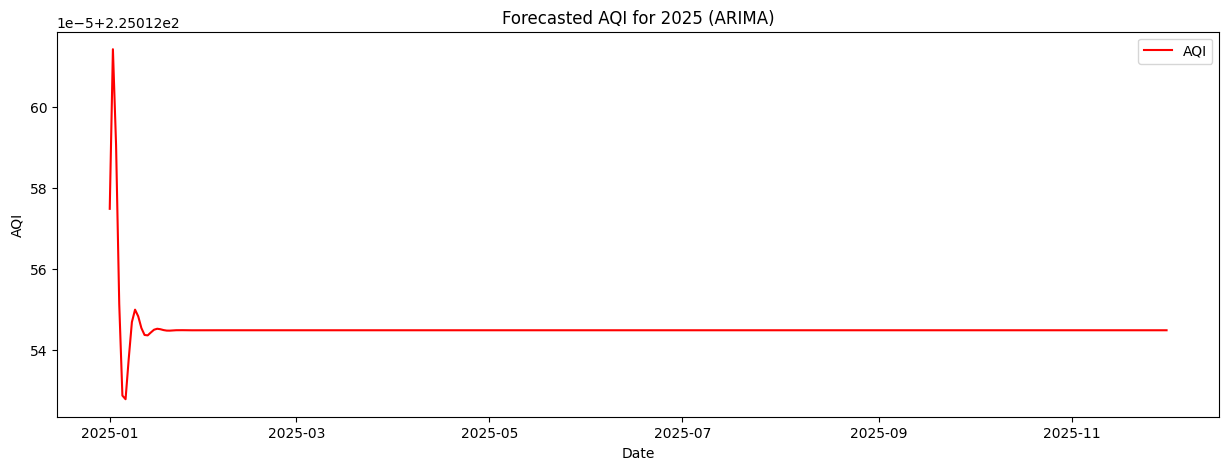

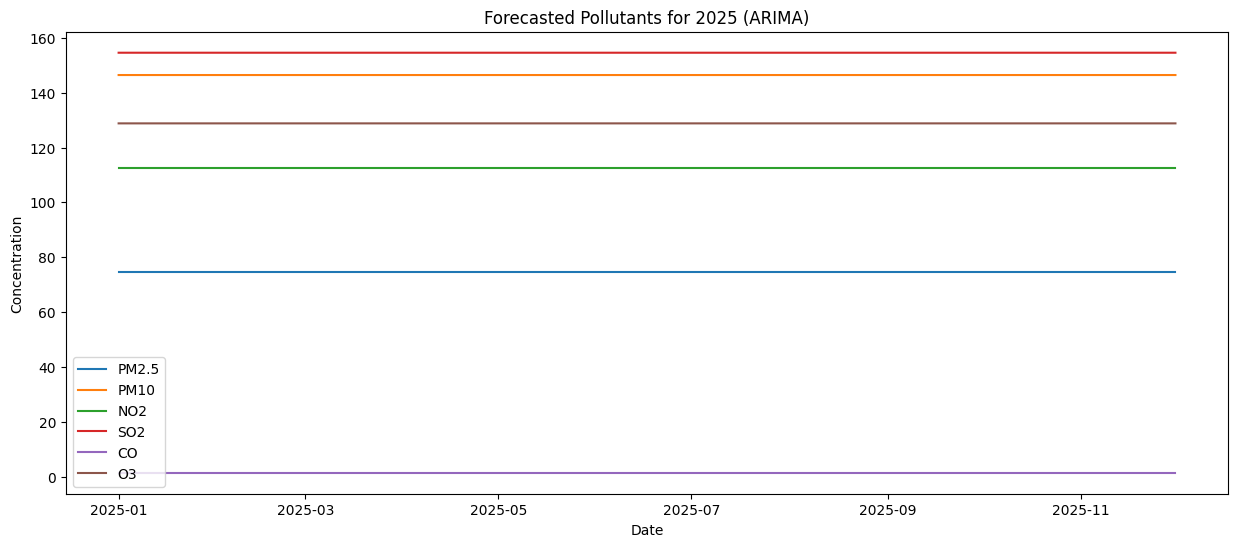

In [51]:
# ------------------------------
# 1️⃣ Imports
# ------------------------------
import pandas as pd
import numpy as np
import pickle
from datetime import timedelta
import matplotlib.pyplot as plt
from google.colab import files

# ------------------------------
# 2️⃣ Load trained ARIMA models
# ------------------------------
pollutants = ['PM2.5','PM10','NO2','SO2','CO','O3']
arima_models = {}

for col in pollutants:
    with open(f'ARIMA_{col}.pkl', 'rb') as f:
        arima_models[col] = pickle.load(f)

# ------------------------------
# 3️⃣ Forecast all of 2025
# ------------------------------
last_date = df_daily.index[-1]  # last date of training data
forecast_start = last_date + pd.Timedelta(days=1)
forecast_end = pd.Timestamp('2025-12-31')
future_dates = pd.date_range(start=forecast_start, end=forecast_end)

forecast_dict = {}
for col, model in arima_models.items():
    forecast_values = model.forecast(steps=len(future_dates))
    forecast_dict[col] = pd.Series(forecast_values, index=future_dates)

forecast_df = pd.DataFrame(forecast_dict)

# ------------------------------
# 4️⃣ Compute realistic AQI
# ------------------------------
aqi_breakpoints = {
    'PM2.5': [(0,12,0,50),(12.1,35.4,51,100),(35.5,55.4,101,150),(55.5,150.4,151,200),
              (150.5,250.4,201,300),(250.5,350.4,301,400),(350.5,500.4,401,500)],
    'PM10': [(0,54,0,50),(55,154,51,100),(155,254,101,150),(255,354,151,200),
             (355,424,201,300),(425,504,301,400),(505,604,401,500)],
    'NO2': [(0,53,0,50),(54,100,51,100),(101,360,101,150),(361,649,151,200),
            (650,1249,201,300),(1250,1649,301,400),(1650,2049,401,500)],
    'SO2': [(0,35,0,50),(36,75,51,100),(76,185,101,150),(186,304,151,200),
            (305,604,201,300),(605,804,301,400),(805,1004,401,500)],
    'CO': [(0,4.4,0,50),(4.5,9.4,51,100),(9.5,12.4,101,150),(12.5,15.4,151,200),
           (15.5,30.4,201,300),(30.5,40.4,301,400),(40.5,50.4,401,500)],
    'O3': [(0,54,0,50),(55,70,51,100),(71,85,101,150),(86,105,151,200),
           (106,200,201,300),(201,300,301,400),(301,400,401,500)]
}

def compute_individual_aqi(pollutant, conc):
    breakpoints = aqi_breakpoints[pollutant]
    for (C_low, C_high, I_low, I_high) in breakpoints:
        if C_low <= conc <= C_high:
            return ((I_high - I_low)/(C_high - C_low))*(conc - C_low) + I_low
    return None  # outside breakpoints

def compute_aqi_row(row):
    aqi_values = []
    for p in pollutants:
        val = compute_individual_aqi(p, row[p])
        if val is not None:
            aqi_values.append(val)
    return max(aqi_values) if aqi_values else np.nan

forecast_df['AQI'] = forecast_df.apply(compute_aqi_row, axis=1)

# ------------------------------
# 5️⃣ Save forecast CSV
# ------------------------------
forecast_df.to_csv('forecasted_AQI_2025_ARIMA.csv')
files.download('forecasted_AQI_2025_ARIMA.csv')

# ------------------------------
# 6️⃣ Plot AQI trend
# ------------------------------
plt.figure(figsize=(15,5))
plt.plot(forecast_df.index, forecast_df['AQI'], label='AQI', color='red')
plt.title('Forecasted AQI for 2025 (ARIMA)')
plt.ylabel('AQI')
plt.xlabel('Date')
plt.legend()
plt.show()

# Optional: plot all pollutants
plt.figure(figsize=(15,6))
for col in pollutants:
    plt.plot(forecast_df.index, forecast_df[col], label=col)
plt.title('Forecasted Pollutants for 2025 (ARIMA)')
plt.ylabel('Concentration')
plt.xlabel('Date')
plt.legend()
plt.show()


Saving cleaned_AQI_dataset.csv to cleaned_AQI_dataset (10).csv
Loaded cleaned_AQI_dataset (10).csv with shape (12042, 8)


City    AQI   PM2.5    PM10     NO2     SO2    CO      O3
Date                                                                      
2018-01-01  Bangalore   68.0   37.40   73.44   56.44   77.52  0.71   64.60
2018-01-01    Chennai   93.0   51.15  100.44   77.19  106.02  0.98   88.35
2018-01-01  Hyderabad  119.0   65.45  128.52   98.77  135.66  1.25  113.05
2018-01-01      Delhi  406.0  223.30  438.48  336.98  462.84  4.26  385.70
2018-01-02      Delhi  418.0  229.90  451.44  346.94  476.52  4.39  397.10

Using ARIMA models trained on the full dataset.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

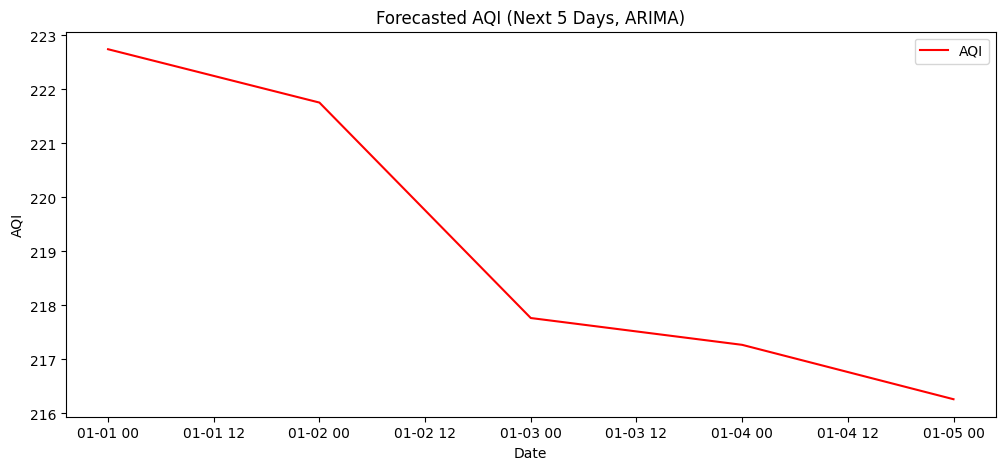

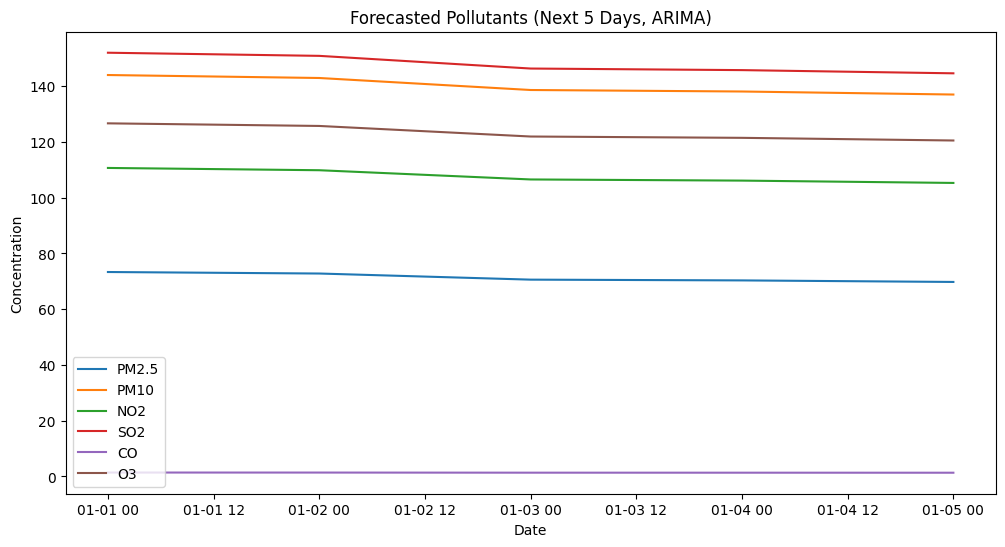

In [55]:
# ------------------------------
# 1️⃣ Imports
# ------------------------------
import pandas as pd
import numpy as np
import pickle
from datetime import timedelta
import matplotlib.pyplot as plt
from google.colab import files

# ------------------------------
# 2️⃣ Upload CSV and read
# ------------------------------
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]

# Read the CSV, automatically detect date column, and set index
df_new = pd.read_csv(csv_path, low_memory=False)

# Find date column candidates and select one
date_col_candidates = [c for c in df_new.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
if not date_col_candidates:
    raise ValueError("No date or time column found in the uploaded CSV.")
date_col = date_col_candidates[0]

# Convert to datetime and set as index
df_new[date_col] = pd.to_datetime(df_new[date_col], errors='coerce')
df_new = df_new.dropna(subset=[date_col]).sort_values(by=date_col).set_index(date_col)

print(f"Loaded {csv_path} with shape {df_new.shape}")
display(df_new.head())


# ------------------------------
# 3️⃣ Load trained ARIMA models (prefer models trained on full data if available)
# ------------------------------
pollutants = ['PM2.5','PM10','NO2','SO2','CO','O3']
arima_models_to_use = {}

# Check if models trained on full data are available from a previous cell
if 'full_data_arima_models' in globals() and full_data_arima_models:
    print("Using ARIMA models trained on the full dataset.")
    arima_models_to_use = full_data_arima_models
else:
    print("Loading ARIMA models from pickle files.")
    for col in pollutants:
        try:
            with open(f'ARIMA_{col}.pkl', 'rb') as f:
                arima_models_to_use[col] = pickle.load(f)
        except FileNotFoundError:
            print(f"ARIMA model for {col} not found. Skipping this pollutant.")

pollutants_to_forecast = list(arima_models_to_use.keys())

if not pollutants_to_forecast:
    raise ValueError("No ARIMA models available for forecasting for the specified pollutants.")


# ------------------------------
# 4️⃣ Forecast settings
# ------------------------------
# Use the last date of the newly uploaded data for forecasting start
last_date_new_data = df_new.index[-1]
forecast_days = 5 # Fixed to 5 days as per the original cell's intent

future_dates = pd.date_range(start=last_date_new_data + pd.Timedelta(days=1),
                             periods=forecast_days)

# ------------------------------
# 5️⃣ Forecast using ARIMA models
# ------------------------------
forecast_dict = {}
for col in pollutants_to_forecast:
    model = arima_models_to_use[col]
    # Forecast next n days - returns a Series with the correct date index
    forecast_series = model.forecast(steps=forecast_days)
    # Ensure forecast values are non-negative
    forecast_series[forecast_series < 0] = 0
    forecast_dict[col] = forecast_series

forecast_df = pd.DataFrame(forecast_dict)
forecast_df.index.name = 'Date' # Set index name for consistency


# ------------------------------
# 6️⃣ Compute AQI
# ------------------------------
aqi_breakpoints = {
    'PM2.5': [(0,12,0,50),(12.1,35.4,51,100),(35.5,55.4,101,150),(55.5,150.4,151,200),
              (150.5,250.4,201,300),(250.5,350.4,301,400),(350.5,500.4,401,500)],
    'PM10': [(0,54,0,50),(55,154,51,100),(155,254,101,150),(255,354,151,200),
             (355,424,201,300),(425,504,301,400),(505,604,401,500)],
    'NO2': [(0,53,0,50),(54,100,51,100),(101,360,101,150),(361,649,151,200),
            (650,1249,201,300),(1250,1649,301,400),(1650,2049,401,500)],
    'SO2': [(0,35,0,50),(36,75,51,100),(76,185,101,150),(186,304,151,200),
            (305,604,201,300),(605,804,301,400),(805,1004,401,500)],
    'CO': [(0,4.4,0,50),(4.5,9.4,51,100),(9.5,12.4,101,150),(12.5,15.4,151,200),
           (15.5,30.4,201,300),(30.5,40.4,301,400),(40.5,50.4,401,500)],
    'O3': [(0,54,0,50),(55,70,51,100),(71,85,101,150),(86,105,151,200),
           (106,200,201,300),(201,300,301,400),(301,400,401,500)]
}

def compute_individual_aqi(pollutant, conc):
    breakpoints = aqi_breakpoints[pollutant]
    # Handle values below the lowest breakpoint
    if conc < breakpoints[0][0]:
        return breakpoints[0][2]

    for (C_low, C_high, I_low, I_high) in breakpoints:
        if C_low <= conc <= C_high:
            # Avoid division by zero if C_high == C_low
            if C_high == C_low:
                return I_low
            return ((I_high - I_low)/(C_high - C_low))*(conc - C_low) + I_low

    # Handle values above the highest breakpoint
    return breakpoints[-1][3]


def compute_aqi_row(row):
    aqi_values = []
    for p in pollutants_to_forecast: # Use pollutants actually forecasted
        if p in aqi_breakpoints: # Only calculate AQI for pollutants with defined breakpoints
             val = compute_individual_aqi(p, row[p])
             if val is not None: # Ensure compute_individual_aqi returned a value
                 aqi_values.append(val)

    return max(aqi_values) if aqi_values else np.nan # Return NaN if no valid AQI could be calculated

forecast_df['AQI'] = forecast_df.apply(compute_aqi_row, axis=1)


# ------------------------------
# 7️⃣ Save forecast
# ------------------------------
forecast_df.to_csv('forecasted_AQI_5days_ARIMA.csv')
files.download('forecasted_AQI_5days_ARIMA.csv')

# ------------------------------
# 8️⃣ Plot AQI
# ------------------------------
plt.figure(figsize=(12,5))
plt.plot(forecast_df.index, forecast_df['AQI'], label='AQI', color='red')
plt.title('Forecasted AQI (Next 5 Days, ARIMA)')
plt.ylabel('AQI')
plt.xlabel('Date')
plt.legend()
plt.show()

# Optional: plot all pollutants
plt.figure(figsize=(12,6))
for col in pollutants_to_forecast: # Plot only forecasted pollutants
    plt.plot(forecast_df.index, forecast_df[col], label=col)
plt.title('Forecasted Pollutants (Next 5 Days, ARIMA)')
plt.ylabel('Concentration')
plt.xlabel('Date')
plt.legend()
plt.show()

Saving cleaned_AQI_dataset.csv to cleaned_AQI_dataset (11).csv
Loaded cleaned_AQI_dataset (11).csv with shape (12042, 8)


City    AQI   PM2.5    PM10     NO2     SO2    CO      O3
Date                                                                      
2018-01-01  Bangalore   68.0   37.40   73.44   56.44   77.52  0.71   64.60
2018-01-01    Chennai   93.0   51.15  100.44   77.19  106.02  0.98   88.35
2018-01-01  Hyderabad  119.0   65.45  128.52   98.77  135.66  1.25  113.05
2018-01-01      Delhi  406.0  223.30  438.48  336.98  462.84  4.26  385.70
2018-01-02      Delhi  418.0  229.90  451.44  346.94  476.52  4.39  397.10

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

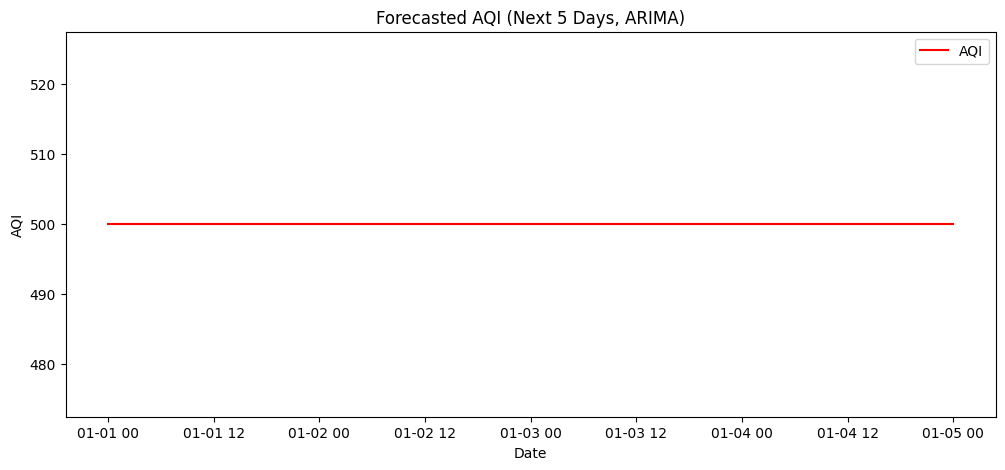

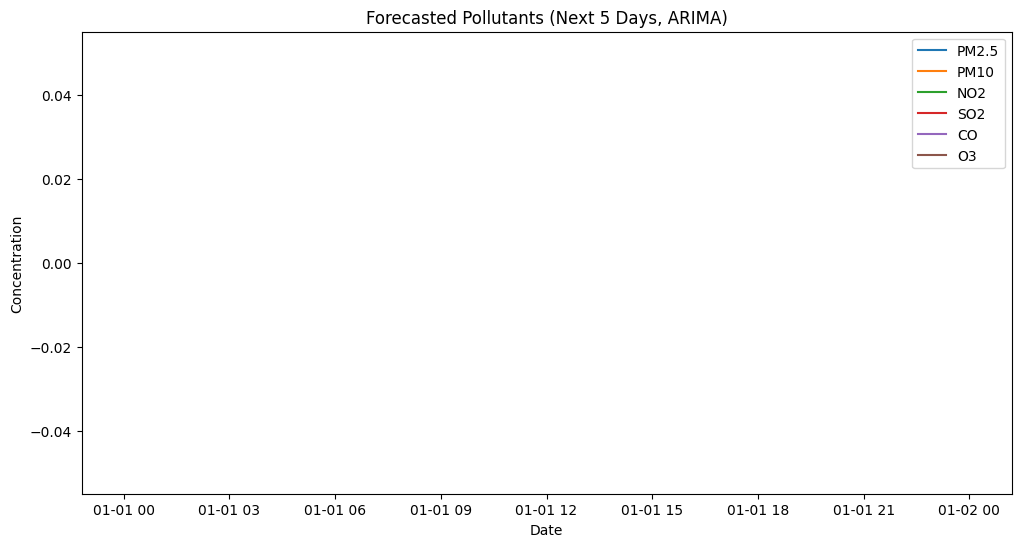

In [58]:
# ------------------------------
# 1️⃣ Imports
# ------------------------------
import pandas as pd
import numpy as np
import pickle
from datetime import timedelta
import matplotlib.pyplot as plt
from google.colab import files

# ------------------------------
# 2️⃣ Upload CSV and read
# ------------------------------
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]

df_new = pd.read_csv(csv_path, low_memory=False)

# Detect date column
date_col_candidates = [c for c in df_new.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
if not date_col_candidates:
    raise ValueError("No date or time column found in the uploaded CSV.")
date_col = date_col_candidates[0]

# Convert to datetime and set as index
df_new[date_col] = pd.to_datetime(df_new[date_col], errors='coerce')
df_new = df_new.dropna(subset=[date_col]).sort_values(by=date_col).set_index(date_col)

print(f"Loaded {csv_path} with shape {df_new.shape}")
display(df_new.head())

# ------------------------------
# 3️⃣ Load trained ARIMA models
# ------------------------------
pollutants = ['PM2.5','PM10','NO2','SO2','CO','O3']
arima_models_to_use = {}

for col in pollutants:
    with open(f'ARIMA_{col}.pkl', 'rb') as f:
        arima_models_to_use[col] = pickle.load(f)

pollutants_to_forecast = list(arima_models_to_use.keys())

# ------------------------------
# 4️⃣ Forecast settings
# ------------------------------
forecast_days = 5  # fixed 5 days
last_date_new_data = df_new.index[-1]
future_dates = pd.date_range(start=last_date_new_data + pd.Timedelta(days=1),
                             periods=forecast_days)

# ------------------------------
# 5️⃣ Forecast using ARIMA
# ------------------------------
forecast_dict = {}
for col in pollutants_to_forecast:
    model = arima_models_to_use[col]  # fitted ARIMA model
    forecast_values = model.forecast(steps=forecast_days)  # returns array
    forecast_values[forecast_values < 0] = 0  # clip negative values
    forecast_dict[col] = pd.Series(forecast_values, index=future_dates)

forecast_df = pd.DataFrame(forecast_dict)
forecast_df.index.name = 'Date'

# ------------------------------
# 6️⃣ Compute AQI
# ------------------------------
aqi_breakpoints = {
    'PM2.5': [(0,12,0,50),(12.1,35.4,51,100),(35.5,55.4,101,150),(55.5,150.4,151,200),
              (150.5,250.4,201,300),(250.5,350.4,301,400),(350.5,500.4,401,500)],
    'PM10': [(0,54,0,50),(55,154,51,100),(155,254,101,150),(255,354,151,200),
             (355,424,201,300),(425,504,301,400),(505,604,401,500)],
    'NO2': [(0,53,0,50),(54,100,51,100),(101,360,101,150),(361,649,151,200),
            (650,1249,201,300),(1250,1649,301,400),(1650,2049,401,500)],
    'SO2': [(0,35,0,50),(36,75,51,100),(76,185,101,150),(186,304,151,200),
            (305,604,201,300),(605,804,301,400),(805,1004,401,500)],
    'CO': [(0,4.4,0,50),(4.5,9.4,51,100),(9.5,12.4,101,150),(12.5,15.4,151,200),
           (15.5,30.4,201,300),(30.5,40.4,301,400),(40.5,50.4,401,500)],
    'O3': [(0,54,0,50),(55,70,51,100),(71,85,101,150),(86,105,151,200),
           (106,200,201,300),(201,300,301,400),(301,400,401,500)]
}

def compute_individual_aqi(pollutant, conc):
    breakpoints = aqi_breakpoints[pollutant]
    if conc < breakpoints[0][0]:
        return breakpoints[0][2]
    for (C_low, C_high, I_low, I_high) in breakpoints:
        if C_low <= conc <= C_high:
            return ((I_high - I_low)/(C_high - C_low))*(conc - C_low) + I_low
    return breakpoints[-1][3]

def compute_aqi_row(row):
    aqi_values = []
    for p in pollutants_to_forecast:
        if p in aqi_breakpoints:
            val = compute_individual_aqi(p, row[p])
            aqi_values.append(val)
    return max(aqi_values) if aqi_values else np.nan

forecast_df['AQI'] = forecast_df.apply(compute_aqi_row, axis=1)

# ------------------------------
# 7️⃣ Save forecast
# ------------------------------
forecast_df.to_csv('forecasted_AQI_5days_ARIMA.csv')
files.download('forecasted_AQI_5days_ARIMA.csv')

# ------------------------------
# 8️⃣ Plot AQI
# ------------------------------
plt.figure(figsize=(12,5))
plt.plot(forecast_df.index, forecast_df['AQI'], label='AQI', color='red')
plt.title('Forecasted AQI (Next 5 Days, ARIMA)')
plt.ylabel('AQI')
plt.xlabel('Date')
plt.legend()
plt.show()

# Optional: plot all pollutants
plt.figure(figsize=(12,6))
for col in pollutants_to_forecast:
    plt.plot(forecast_df.index, forecast_df[col], label=col)
plt.title('Forecasted Pollutants (Next 5 Days, ARIMA)')
plt.ylabel('Concentration')
plt.xlabel('Date')
plt.legend()
plt.show()


Saving sampledelhi.csv to sampledelhi (2).csv
Loaded sampledelhi (2).csv with shape (10, 8)


City  AQI  PM2.5  PM10  NO2  SO2   CO  O3
Date                                                  
2025-03-01  Delhi  120     60   130   90   50  1.2  80
2025-03-02  Delhi  125     62   135   92   52  1.3  82
2025-03-03  Delhi  118     58   128   88   48  1.1  78
2025-03-04  Delhi  130     65   140   95   55  1.4  85
2025-03-05  Delhi  122     61   132   91   51  1.2  81

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

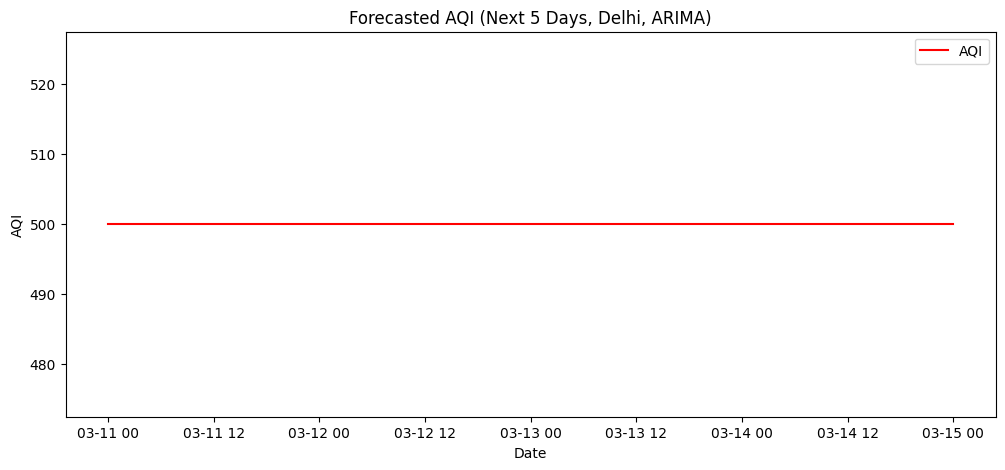

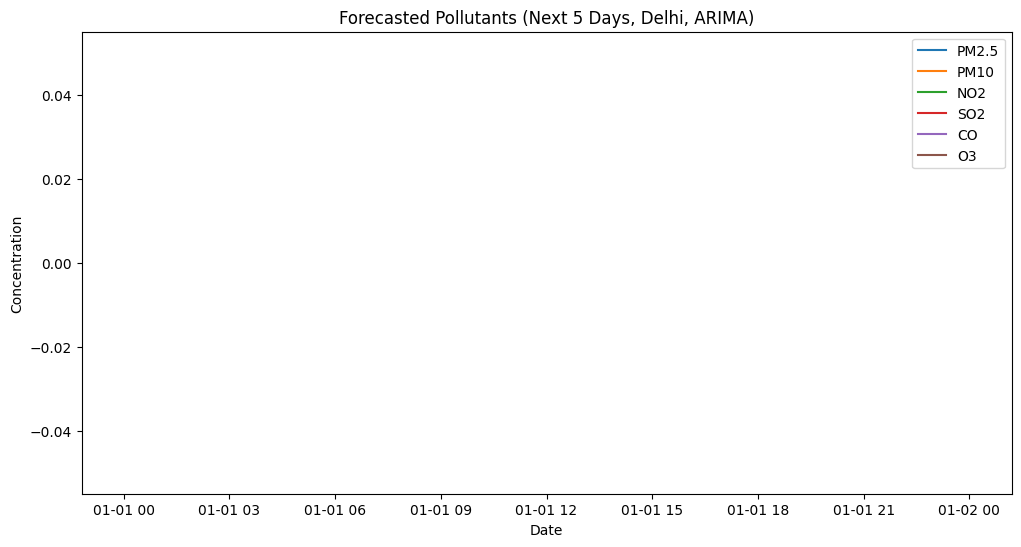

In [63]:
# ------------------------------
# 1️⃣ Imports
# ------------------------------
import pandas as pd
import numpy as np
import pickle
from datetime import timedelta
import matplotlib.pyplot as plt
from google.colab import files

# ------------------------------
# 2️⃣ Upload CSV and read
# ------------------------------
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]

df_new = pd.read_csv(csv_path, low_memory=False)

# ------------------------------
# 3️⃣ Detect date column
# ------------------------------
date_col_candidates = [c for c in df_new.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
if not date_col_candidates:
    raise ValueError("No date or time column found in uploaded CSV.")
date_col = date_col_candidates[0]

# Convert to datetime and set as index
df_new[date_col] = pd.to_datetime(df_new[date_col], errors='coerce')
df_new = df_new.dropna(subset=[date_col]).sort_values(by=date_col)
df_new.set_index(date_col, inplace=True)

print(f"Loaded {csv_path} with shape {df_new.shape}")
display(df_new.head())

# ------------------------------
# 4️⃣ Load ARIMA models
# ------------------------------
pollutants = ['PM2.5','PM10','NO2','SO2','CO','O3']
arima_models = {}
for col in pollutants:
    with open(f'ARIMA_{col}.pkl', 'rb') as f:
        arima_models[col] = pickle.load(f)

pollutants_to_forecast = list(arima_models.keys())

# ------------------------------
# 5️⃣ Forecast settings
# ------------------------------
forecast_days = 5  # fixed 5 days
last_date = df_new.index.max()  # ✅ take the last date of the uploaded CSV
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                             periods=forecast_days)

# Preserve city
if 'City' in df_new.columns:
    city_name = df_new['City'].iloc[-1]  # last row city
else:
    city_name = 'Unknown'

# ------------------------------
# 6️⃣ Forecast using ARIMA
# ------------------------------
forecast_dict = {}
for col in pollutants_to_forecast:
    model = arima_models[col]
    forecast_values = model.forecast(steps=forecast_days)
    forecast_values[forecast_values < 0] = 0
    forecast_dict[col] = pd.Series(forecast_values, index=future_dates)

forecast_df = pd.DataFrame(forecast_dict)
forecast_df['City'] = city_name
forecast_df.index.name = 'Date'

# ------------------------------
# 7️⃣ Compute AQI
# ------------------------------
aqi_breakpoints = {
    'PM2.5': [(0,12,0,50),(12.1,35.4,51,100),(35.5,55.4,101,150),(55.5,150.4,151,200),
              (150.5,250.4,201,300),(250.5,350.4,301,400),(350.5,500.4,401,500)],
    'PM10': [(0,54,0,50),(55,154,51,100),(155,254,101,150),(255,354,151,200),
             (355,424,201,300),(425,504,301,400),(505,604,401,500)],
    'NO2': [(0,53,0,50),(54,100,51,100),(101,360,101,150),(361,649,151,200),
            (650,1249,201,300),(1250,1649,301,400),(1650,2049,401,500)],
    'SO2': [(0,35,0,50),(36,75,51,100),(76,185,101,150),(186,304,151,200),
            (305,604,201,300),(605,804,301,400),(805,1004,401,500)],
    'CO': [(0,4.4,0,50),(4.5,9.4,51,100),(9.5,12.4,101,150),(12.5,15.4,151,200),
           (15.5,30.4,201,300),(30.5,40.4,301,400),(40.5,50.4,401,500)],
    'O3': [(0,54,0,50),(55,70,51,100),(71,85,101,150),(86,105,151,200),
           (106,200,201,300),(201,300,301,400),(301,400,401,500)]
}

def compute_individual_aqi(pollutant, conc):
    breakpoints = aqi_breakpoints[pollutant]
    if conc < breakpoints[0][0]:
        return breakpoints[0][2]
    for (C_low, C_high, I_low, I_high) in breakpoints:
        if C_low <= conc <= C_high:
            return ((I_high - I_low)/(C_high - C_low))*(conc - C_low) + I_low
    return breakpoints[-1][3]

def compute_aqi_row(row):
    aqi_values = [compute_individual_aqi(p, row[p]) for p in pollutants_to_forecast]
    return max(aqi_values) if aqi_values else np.nan

forecast_df['AQI'] = forecast_df.apply(compute_aqi_row, axis=1)

# ------------------------------
# 8️⃣ Save and download
# ------------------------------
forecast_df.to_csv('forecasted_AQI_next5days.csv')
files.download('forecasted_AQI_next5days.csv')

# ------------------------------
# 9️⃣ Plot AQI
# ------------------------------
plt.figure(figsize=(12,5))
plt.plot(forecast_df.index, forecast_df['AQI'], label='AQI', color='red')
plt.title(f'Forecasted AQI (Next 5 Days, {city_name}, ARIMA)')
plt.ylabel('AQI')
plt.xlabel('Date')
plt.legend()
plt.show()

# Optional: plot pollutants
plt.figure(figsize=(12,6))
for col in pollutants_to_forecast:
    plt.plot(forecast_df.index, forecast_df[col], label=col)
plt.title(f'Forecasted Pollutants (Next 5 Days, {city_name}, ARIMA)')
plt.ylabel('Concentration')
plt.xlabel('Date')
plt.legend()
plt.show()


Saving cleaned_AQI_dataset.csv to cleaned_AQI_dataset (15).csv
Loaded cleaned_AQI_dataset (15).csv with shape (12042, 8)


City    AQI   PM2.5    PM10     NO2     SO2    CO      O3
Date                                                                      
2018-01-01  Bangalore   68.0   37.40   73.44   56.44   77.52  0.71   64.60
2018-01-01    Chennai   93.0   51.15  100.44   77.19  106.02  0.98   88.35
2018-01-01  Hyderabad  119.0   65.45  128.52   98.77  135.66  1.25  113.05
2018-01-01      Delhi  406.0  223.30  438.48  336.98  462.84  4.26  385.70
2018-01-02      Delhi  418.0  229.90  451.44  346.94  476.52  4.39  397.10

Forecasting for city: Bangalore


/tmp/ipython-input-708292558.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/s

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

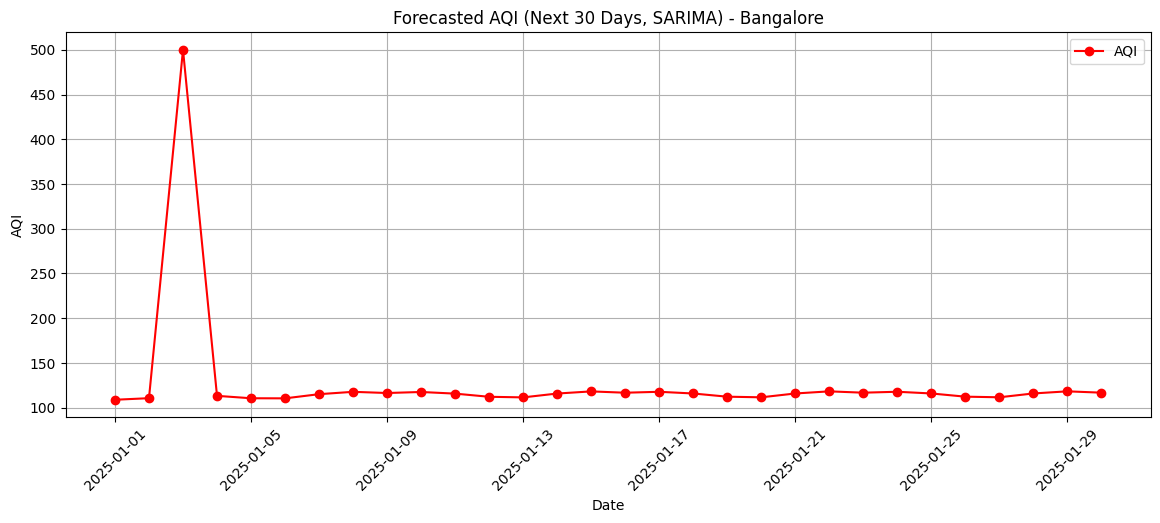

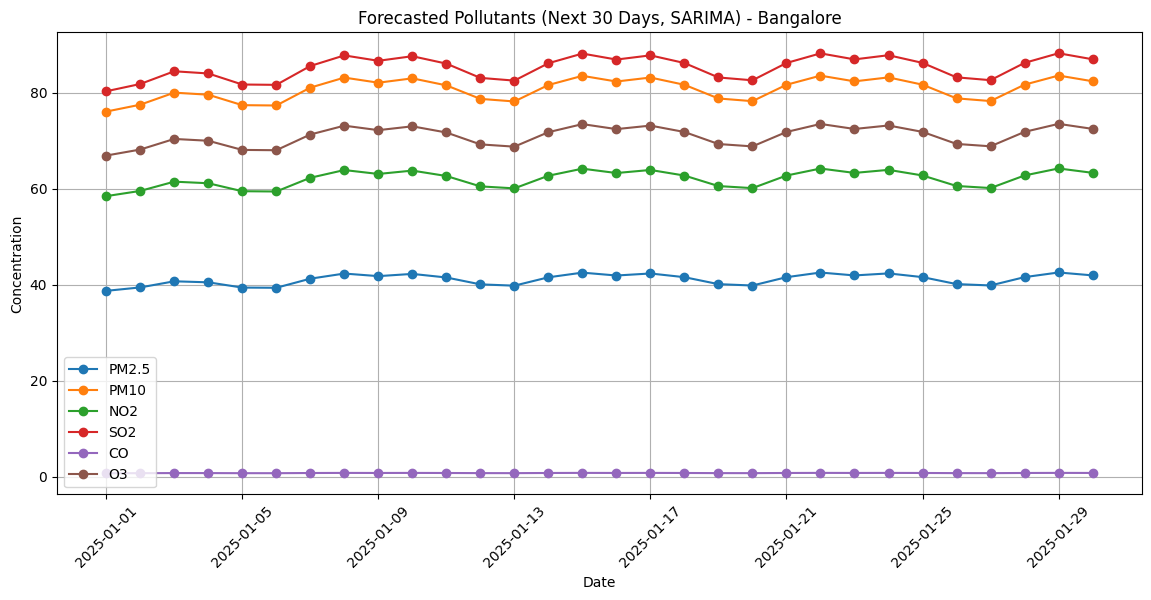

In [66]:
# ------------------------------
# 1️⃣ Imports
# ------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from google.colab import files

# ------------------------------
# 2️⃣ Upload CSV and read
# ------------------------------
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]

df_new = pd.read_csv(csv_path, low_memory=False)

# Detect date column
date_col_candidates = [c for c in df_new.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
if not date_col_candidates:
    raise ValueError("No date or time column found in the uploaded CSV.")
date_col = date_col_candidates[0]

# Convert to datetime and set as index
df_new[date_col] = pd.to_datetime(df_new[date_col], errors='coerce')
df_new = df_new.dropna(subset=[date_col]).sort_values(by=date_col).set_index(date_col)

print(f"Loaded {csv_path} with shape {df_new.shape}")
display(df_new.head())

# ------------------------------
# 3️⃣ Select a single city for forecasting
# ------------------------------
city_name = df_new['City'].unique()[0]
df_city = df_new[df_new['City'] == city_name].copy()
print(f"Forecasting for city: {city_name}")

# ------------------------------
# 4️⃣ Forecast settings
# ------------------------------
pollutants = ['PM2.5','PM10','NO2','SO2','CO','O3']
forecast_days = 30  # next 30 days
future_dates = pd.date_range(start=df_city.index[-1] + pd.Timedelta(days=1),
                             periods=forecast_days)

# ------------------------------
# 5️⃣ Forecast using SARIMA (seasonal daily pattern)
# ------------------------------
forecast_dict = {}
for col in pollutants:
    ts = df_city[col].astype(float)
    ts = ts.fillna(method='ffill').fillna(method='bfill')
    # SARIMA: order=(1,1,1), seasonal_order=(1,1,1,7) for weekly seasonality
    model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast_values = model_fit.forecast(steps=forecast_days)
    forecast_values[forecast_values < 0] = 0  # clip negatives
    forecast_dict[col] = pd.Series(forecast_values.values, index=future_dates)

forecast_df = pd.DataFrame(forecast_dict)
forecast_df.index.name = 'Date'
forecast_df['City'] = city_name

# ------------------------------
# 6️⃣ Compute AQI
# ------------------------------
aqi_breakpoints = {
    'PM2.5': [(0,12,0,50),(12.1,35.4,51,100),(35.5,55.4,101,150),(55.5,150.4,151,200),
              (150.5,250.4,201,300),(250.5,350.4,301,400),(350.5,500.4,401,500)],
    'PM10': [(0,54,0,50),(55,154,51,100),(155,254,101,150),(255,354,151,200),
             (355,424,201,300),(425,504,301,400),(505,604,401,500)],
    'NO2': [(0,53,0,50),(54,100,51,100),(101,360,101,150),(361,649,151,200),
            (650,1249,201,300),(1250,1649,301,400),(1650,2049,401,500)],
    'SO2': [(0,35,0,50),(36,75,51,100),(76,185,101,150),(186,304,151,200),
            (305,604,201,300),(605,804,301,400),(805,1004,401,500)],
    'CO': [(0,4.4,0,50),(4.5,9.4,51,100),(9.5,12.4,101,150),(12.5,15.4,151,200),
           (15.5,30.4,201,300),(30.5,40.4,301,400),(40.5,50.4,401,500)],
    'O3': [(0,54,0,50),(55,70,51,100),(71,85,101,150),(86,105,151,200),
           (106,200,201,300),(201,300,301,400),(301,400,401,500)]
}

def compute_individual_aqi(pollutant, conc):
    breakpoints = aqi_breakpoints[pollutant]
    if conc < breakpoints[0][0]:
        return breakpoints[0][2]
    for (C_low, C_high, I_low, I_high) in breakpoints:
        if C_low <= conc <= C_high:
            return ((I_high - I_low)/(C_high - C_low))*(conc - C_low) + I_low
    return breakpoints[-1][3]

def compute_aqi_row(row):
    aqi_values = []
    for p in pollutants:
        if p in aqi_breakpoints:
            val = compute_individual_aqi(p, row[p])
            aqi_values.append(val)
    return max(aqi_values) if aqi_values else np.nan

forecast_df['AQI'] = forecast_df.apply(compute_aqi_row, axis=1)

# ------------------------------
# 7️⃣ Save forecast
# ------------------------------
forecast_df.to_csv('forecasted_AQI_30days_SARIMA.csv')
files.download('forecasted_AQI_30days_SARIMA.csv')

# ------------------------------
# 8️⃣ Plot AQI
# ------------------------------
plt.figure(figsize=(14,5))
plt.plot(forecast_df.index, forecast_df['AQI'], label='AQI', color='red', marker='o')
plt.title(f'Forecasted AQI (Next {forecast_days} Days, SARIMA) - {city_name}')
plt.ylabel('AQI')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# Optional: plot all pollutants
plt.figure(figsize=(14,6))
for col in pollutants:
    plt.plot(forecast_df.index, forecast_df[col], label=col, marker='o')
plt.title(f'Forecasted Pollutants (Next {forecast_days} Days, SARIMA) - {city_name}')
plt.ylabel('Concentration')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()
